In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from support_code.model import DQN
from support_code.env import TradingEnv
from support_code.functions import fetch_data, buy_and_hold, pickle_model, corr

In [2]:
import warnings
warnings.simplefilter('ignore')

---
---
---
### Random back testing

In [4]:
df = fetch_data('aapl_df')

starting_balance = 1_000_000

env = TradingEnv(df, balance_init=starting_balance)
env.verbose=1

In [5]:
np.random.seed(None)
env.seed(None)

In [6]:
done = False
obs = env.reset()
start = env.current_step

stock_performance = []
model_performance = []
actions = []

while not done:
    
    stock_performance.append(df.loc[env.current_step]['close'])
    model_performance.append(env.net_worth)
        
    action = np.random.randint(env.action_space.n)
    obs, rewards, done, info = env.step(action)

    actions.append(env._actions[action])
    
end = env.current_step

current price 19.470715
action -1.0
total possible to sell 0
number sold 0.0
profit from selling 0.0
balance 1000000.0 shares held 0.0
previous net worth 1000000 current net worth 1000000.0

current price 19.04143
action -0.25
total possible to sell 0.0
number sold 0.0
profit from selling 0.0
balance 1000000.0 shares held 0.0
previous net worth 1000000.0 current net worth 1000000.0

current price 18.937857
action 0.5
total possible to buy 52751.53355530138
number bought 26375.76677765069
cost of buying 500000.0
balance 500000.0 shares held 26375.76677765069
previous net worth 1000000.0 current net worth 999500.4995004996

current price 18.953215
action 0.75
total possible to buy 26354.394201748863
number bought 19765.795651311648
cost of buying 375000.0
balance 125000.0 shares held 46141.56242896234
previous net worth 999500.4995004996 current net worth 999530.9531520454

current price 19.356785000000002
action -0.5
total possible to sell 46141.56242896234
number sold 23070.78121448117

previous net worth 1020774.4464498383 current net worth 1028272.4644155845

current price 20.684642999999998
action 0.0
balance 143522.05119910702 shares held 43289.02987832045
previous net worth 1028272.4644155845 current net worth 1038940.1800484988

current price 20.633215
action -0.25
total possible to sell 43289.02987832045
number sold 10822.257469580112
profit from selling 223074.66719004718
balance 366596.7183891542 shares held 32466.772408740337
previous net worth 1038940.1800484988 current net worth 1036490.6138547615

current price 20.035357
action 0.0
balance 366596.7183891542 shares held 32466.772408740337
previous net worth 1036490.6138547615 current net worth 1017080.0942360167

current price 20.153214000000002
action 0.0
balance 366596.7183891542 shares held 32466.772408740337
previous net worth 1017080.0942360167 current net worth 1020906.5306317937

current price 20.101072
action 0.0
balance 366596.7183891542 shares held 32466.772408740337
previous net worth 1020906.53

current price 22.726429
action 0.75
total possible to buy 48657.46276425169
number bought 36493.09707318877
cost of buying 830187.1374035563
balance 276729.0458011854 shares held 36493.09707318877
previous net worth 1106916.1832047417 current net worth 1106086.8254251177

current price 23.146786
action 0.0
balance 276729.0458011854 shares held 36493.09707318877
previous net worth 1106086.8254251177 current net worth 1121426.9542315123

current price 23.755357999999998
action -1.0
total possible to sell 36493.09707318877
number sold 36493.09707318877
profit from selling 866039.6789168491
balance 1142768.7247180345 shares held 0.0
previous net worth 1121426.9542315123 current net worth 1142768.7247180345

current price 23.430714000000002
action -0.5
total possible to sell 0.0
number sold 0.0
profit from selling 0.0
balance 1142768.7247180345 shares held 0.0
previous net worth 1142768.7247180345 current net worth 1142768.7247180345

current price 23.888214
action -0.5
total possible to se

---

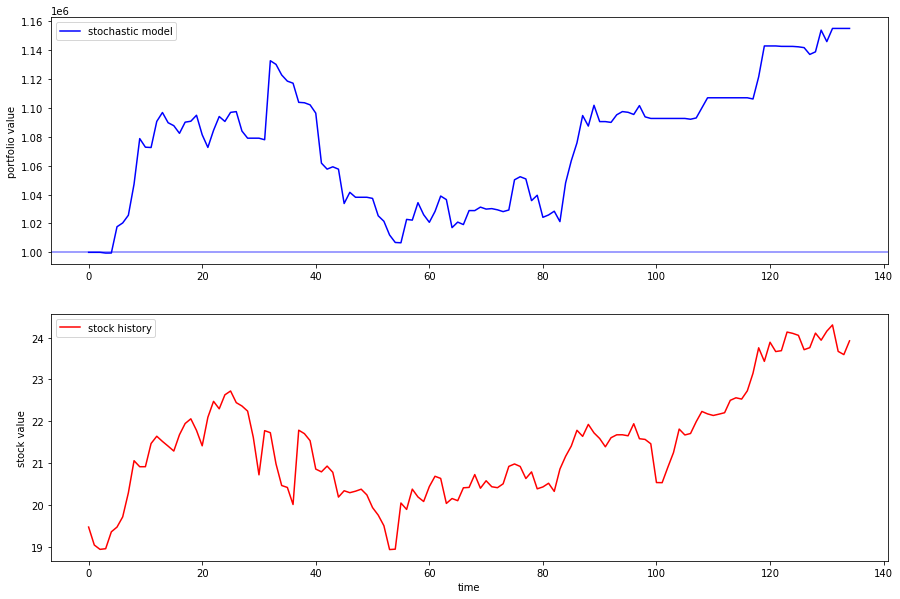

In [7]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(model_performance, 'b-', label='stochastic model')
ax1.set_ylabel('portfolio value')
ax1.axhline(starting_balance, alpha=0.5, color='blue')
ax1.legend()

ax2.plot(stock_performance, 'r-', label='stock history')
ax2.set_ylabel('stock value')
ax2.set_xlabel('time')
ax2.legend()

plt.show();

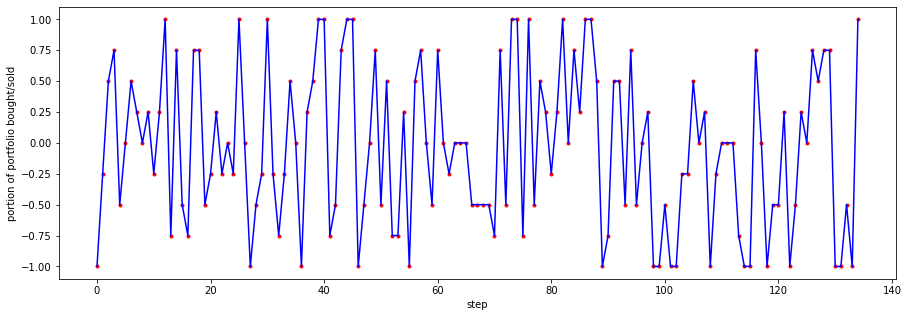

In [8]:
plt.figure(figsize=(15,5))
plt.plot(actions, 'r.')
plt.plot(actions, 'b-')
plt.xlabel('step')
plt.ylabel('portion of portfolio bought/sold')

plt.show();

In [9]:
corr(actions, stock_performance)

0.0675139652096318

---
---
---
### Training/backtesting

In [10]:
df = fetch_data('aapl_df')
#df.shape

In [11]:
np.random.seed(None)

starting_balance = 1_000_000

env = TradingEnv(df, balance_init=starting_balance)
env.verbose=0
env.seed(None)

#print(env.action_space, env.observation_space)

In [15]:
dqn_solver = DQN(
    action_space=env.action_space.n, 
    state_space=env.observation_space.shape,
    batch_size=64,
    memory_size=1_000_000,
    alpha=1.0,
    alpha_decay=0.999,
    alpha_min=0.1,
    gamma=0.99,
    )

dqn_solver.verbose = 0
#dqn_solver.model.summary()

In [16]:
history = []

In [ ]:
for i in np.arange(2000):
    
    # Reset the evironment at the top of each episode
    state = env.reset()
    
    stock_performance = []
    model_performance = []
    reward_trace = []    
    actions = []
    
    start = env.current_step
    done = False    
    
    # The model will iterate until a terminal state is reached
    while not done:
                
        # Select an action by passing the current observation/state to the DQN
        action = dqn_solver.act(state)
        
        # The environment takes a step according to that action and returns the new state, the reward, and the terminal status
        next_state, reward, done, info = env.step(action)
                
        # Commit to the DQN's memory the relevant information
        dqn_solver.remember(state, action, reward, next_state, done)
        
        # Update the current state
        state = next_state

        actions.append(action)
        reward_trace.append(reward)
        model_performance.append(env.net_worth)  
        stock_performance.append(df.loc[env.current_step]['close'])
            
    print('================================================================================================================')
    print(i+1)
    print('FINAL PROFIT', env.net_worth-env.balance_init)
    print('TOTAL REWARD:', np.mean(reward_trace))
    print('DAY RANGE:', start, env.current_step)
    print('EXPLORATION:', dqn_solver.alpha)
    print('MEMORY SIZE:', len(dqn_solver.memory))
    print('================================================================================================================')
    
    # After each episode, perform experience replay
    test = dqn_solver.replay()  
    
    print('\n\n\n')
    
    history.append({
        'stock': stock_performance,
        'model': model_performance,
        'actions': actions,
        'rewards': np.mean(reward_trace),
        })

X, y = test

1
FINAL PROFIT 166500.5149178647
TOTAL REWARD: -23.538473852947313
DAY RANGE: 729 850
EXPLORATION: 1.0
MEMORY SIZE: 121




2
FINAL PROFIT -43214.8079479615
TOTAL REWARD: 0.6056546528959023
DAY RANGE: 1254 1304
EXPLORATION: 0.999
MEMORY SIZE: 171




3
FINAL PROFIT 72285.95126422774
TOTAL REWARD: -1.5579984056889378
DAY RANGE: 1886 1923
EXPLORATION: 0.998001
MEMORY SIZE: 208




4
FINAL PROFIT 131042.98465793207
TOTAL REWARD: -1.8762790448997124
DAY RANGE: 1323 1365
EXPLORATION: 0.997002999
MEMORY SIZE: 250




5
FINAL PROFIT 318405.16390039166
TOTAL REWARD: -11.581881720646747
DAY RANGE: 753 844
EXPLORATION: 0.996005996001
MEMORY SIZE: 341




6
FINAL PROFIT -22876.75042756356
TOTAL REWARD: -0.02219368473548978
DAY RANGE: 164 171
EXPLORATION: 0.995009990004999
MEMORY SIZE: 348




7
FINAL PROFIT -17206.217716985848
TOTAL REWARD: -2.3736032829151066
DAY RANGE: 2107 2194
EXPLORATION: 0.994014980014994
MEMORY SIZE: 435




8
FINAL PROFIT 52685.61615213193
TOTAL REWARD: -7.11813595968039






24
FINAL PROFIT 38345.858189390856
TOTAL REWARD: -1.3486419655389477
DAY RANGE: 2129 2212
EXPLORATION: 0.9772512378214517
MEMORY SIZE: 1377




25
FINAL PROFIT 14168.350385174737
TOTAL REWARD: 0.3596672243394689
DAY RANGE: 1400 1417
EXPLORATION: 0.9762739865836303
MEMORY SIZE: 1394




26
FINAL PROFIT 10862.04941847222
TOTAL REWARD: 2.763602357716955
DAY RANGE: 2260 2356
EXPLORATION: 0.9752977125970467
MEMORY SIZE: 1490




27
FINAL PROFIT 78139.27140069334
TOTAL REWARD: -0.4677287469666663
DAY RANGE: 2215 2234
EXPLORATION: 0.9743224148844496
MEMORY SIZE: 1509




28
FINAL PROFIT 82587.09787475923
TOTAL REWARD: -23.876693868784667
DAY RANGE: 272 400
EXPLORATION: 0.9733480924695651
MEMORY SIZE: 1637




29
FINAL PROFIT 14958.453158338089
TOTAL REWARD: -0.05990262818361795
DAY RANGE: 1200 1207
EXPLORATION: 0.9723747443770956
MEMORY SIZE: 1644




30
FINAL PROFIT 47413.90589070227
TOTAL REWARD: -0.38269373519108424
DAY RANGE: 426 441
EXPLORATION: 0.9714023696327185
MEMORY SIZE: 1659







47
FINAL PROFIT 34814.263009701506
TOTAL REWARD: -2.344281320697724
DAY RANGE: 2192 2277
EXPLORATION: 0.9550199818235596
MEMORY SIZE: 2690




48
FINAL PROFIT -999.0009990008548
TOTAL REWARD: -0.02588547579196596
DAY RANGE: 331 333
EXPLORATION: 0.9540649618417361
MEMORY SIZE: 2692




49
FINAL PROFIT 52089.92926835595
TOTAL REWARD: -22.721742786373582
DAY RANGE: 1961 2181
EXPLORATION: 0.9531108968798944
MEMORY SIZE: 2912




50
FINAL PROFIT -16195.329374765977
TOTAL REWARD: -9.21680338432372
DAY RANGE: 395 478
EXPLORATION: 0.9521577859830145
MEMORY SIZE: 2995




51
FINAL PROFIT -21433.529772707727
TOTAL REWARD: 0.15970054560014396
DAY RANGE: 1610 1627
EXPLORATION: 0.9512056281970315
MEMORY SIZE: 3012




52
FINAL PROFIT 87834.3058630256
TOTAL REWARD: -5.575875373193069
DAY RANGE: 1128 1184
EXPLORATION: 0.9502544225688344
MEMORY SIZE: 3068




53
FINAL PROFIT 51993.226091865916
TOTAL REWARD: -1.4994194052856424
DAY RANGE: 2031 2057
EXPLORATION: 0.9493041681462656
MEMORY SIZE: 3094






70
FINAL PROFIT 2118.628060580464
TOTAL REWARD: -0.3384461017385887
DAY RANGE: 2226 2261
EXPLORATION: 0.933294459381294
MEMORY SIZE: 4128




71
FINAL PROFIT 42546.35961514374
TOTAL REWARD: -0.05914762556823528
DAY RANGE: 1048 1066
EXPLORATION: 0.9323611649219127
MEMORY SIZE: 4146




72
FINAL PROFIT 95333.69157186104
TOTAL REWARD: -4.925590009847506
DAY RANGE: 1315 1391
EXPLORATION: 0.9314288037569908
MEMORY SIZE: 4222




73
FINAL PROFIT -18180.594542860286
TOTAL REWARD: -0.715094218574562
DAY RANGE: 1559 1649
EXPLORATION: 0.9304973749532338
MEMORY SIZE: 4312




74
FINAL PROFIT -101366.4980656514
TOTAL REWARD: -10.836445947010324
DAY RANGE: 1120 1205
EXPLORATION: 0.9295668775782806
MEMORY SIZE: 4397




75
FINAL PROFIT -95108.63926011475
TOTAL REWARD: -1.8273569913472216
DAY RANGE: 1076 1130
EXPLORATION: 0.9286373107007023
MEMORY SIZE: 4451




76
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 2084 2085
EXPLORATION: 0.9277086733900016
MEMORY SIZE: 4452




77
FINAL





93
FINAL PROFIT -185667.40880394366
TOTAL REWARD: -5.448781597617355
DAY RANGE: 353 410
EXPLORATION: 0.9120631656822724
MEMORY SIZE: 5275




94
FINAL PROFIT -20283.32345970266
TOTAL REWARD: -0.012855947866573464
DAY RANGE: 1748 1750
EXPLORATION: 0.9111511025165902
MEMORY SIZE: 5277




95
FINAL PROFIT -46544.17879888124
TOTAL REWARD: 0.12669529021421133
DAY RANGE: 1865 1885
EXPLORATION: 0.9102399514140735
MEMORY SIZE: 5297




96
FINAL PROFIT 14569.17496684054
TOTAL REWARD: 0.004646403653100133
DAY RANGE: 1538 1544
EXPLORATION: 0.9093297114626595
MEMORY SIZE: 5303




97
FINAL PROFIT 21822.551154851215
TOTAL REWARD: 0.9929603070602471
DAY RANGE: 982 998
EXPLORATION: 0.9084203817511969
MEMORY SIZE: 5319




98
FINAL PROFIT -52205.189763356
TOTAL REWARD: -6.129191481486359
DAY RANGE: 848 907
EXPLORATION: 0.9075119613694457
MEMORY SIZE: 5378




99
FINAL PROFIT 214127.96097257384
TOTAL REWARD: -41.61123417118694
DAY RANGE: 1332 1540
EXPLORATION: 0.9066044494080763
MEMORY SIZE: 5586







116
FINAL PROFIT 61664.12492455123
TOTAL REWARD: -1.1707777220753337
DAY RANGE: 1380 1436
EXPLORATION: 0.8913148576343527
MEMORY SIZE: 6602




117
FINAL PROFIT -43743.17590068339
TOTAL REWARD: -0.2714760386943106
DAY RANGE: 258 290
EXPLORATION: 0.8904235427767183
MEMORY SIZE: 6634




118
FINAL PROFIT 485875.0722139892
TOTAL REWARD: -22.013477119416187
DAY RANGE: 95 254
EXPLORATION: 0.8895331192339416
MEMORY SIZE: 6793




119
FINAL PROFIT -46162.03584056697
TOTAL REWARD: -0.6268241220648003
DAY RANGE: 1025 1080
EXPLORATION: 0.8886435861147077
MEMORY SIZE: 6848




120
FINAL PROFIT -53810.68950153212
TOTAL REWARD: -7.642859154630144
DAY RANGE: 1769 1924
EXPLORATION: 0.887754942528593
MEMORY SIZE: 7003




121
FINAL PROFIT -87882.919303764
TOTAL REWARD: -1.047225204132549
DAY RANGE: 1177 1205
EXPLORATION: 0.8868671875860644
MEMORY SIZE: 7031




122
FINAL PROFIT 4524.1649167144205
TOTAL REWARD: -0.23525867014620722
DAY RANGE: 1688 1717
EXPLORATION: 0.8859803203984784
MEMORY SIZE: 7





139
FINAL PROFIT 62185.2523649151
TOTAL REWARD: -1.1984052192745043
DAY RANGE: 1378 1420
EXPLORATION: 0.8710385479118223
MEMORY SIZE: 8097




140
FINAL PROFIT 133499.93535211263
TOTAL REWARD: -3.610589556079577
DAY RANGE: 2133 2261
EXPLORATION: 0.8701675093639105
MEMORY SIZE: 8225




141
FINAL PROFIT 329071.9763417791
TOTAL REWARD: -80.44379849767395
DAY RANGE: 95 332
EXPLORATION: 0.8692973418545467
MEMORY SIZE: 8462




142
FINAL PROFIT 76259.84939820366
TOTAL REWARD: -20.441259643384747
DAY RANGE: 1922 2109
EXPLORATION: 0.8684280445126921
MEMORY SIZE: 8649




143
FINAL PROFIT 211324.4932194571
TOTAL REWARD: -14.108449578510221
DAY RANGE: 644 857
EXPLORATION: 0.8675596164681794
MEMORY SIZE: 8862




144
FINAL PROFIT -13091.371453746688
TOTAL REWARD: 0.03469759477097238
DAY RANGE: 299 307
EXPLORATION: 0.8666920568517111
MEMORY SIZE: 8870




145
FINAL PROFIT -54324.1141142546
TOTAL REWARD: 1.4233713911740502
DAY RANGE: 1756 1791
EXPLORATION: 0.8658253647948594
MEMORY SIZE: 8905






162
FINAL PROFIT -180297.78112987813
TOTAL REWARD: 11.460556438909745
DAY RANGE: 1535 1854
EXPLORATION: 0.8512234991370281
MEMORY SIZE: 10276




163
FINAL PROFIT -19115.357067653676
TOTAL REWARD: 0.05230657409335743
DAY RANGE: 1240 1248
EXPLORATION: 0.8503722756378911
MEMORY SIZE: 10284




164
FINAL PROFIT 19111.779223186197
TOTAL REWARD: 0.015323277041441642
DAY RANGE: 1948 1959
EXPLORATION: 0.8495219033622532
MEMORY SIZE: 10295




165
FINAL PROFIT 67744.21658445452
TOTAL REWARD: -0.39672204992719184
DAY RANGE: 1078 1105
EXPLORATION: 0.8486723814588909
MEMORY SIZE: 10322




166
FINAL PROFIT -30016.375731730834
TOTAL REWARD: -0.62221098901691
DAY RANGE: 1543 1621
EXPLORATION: 0.847823709077432
MEMORY SIZE: 10400




167
FINAL PROFIT 63960.532209078316
TOTAL REWARD: -0.5920907437229148
DAY RANGE: 2344 2356
EXPLORATION: 0.8469758853683546
MEMORY SIZE: 10412




168
FINAL PROFIT -38717.25358094531
TOTAL REWARD: -32.302948636005006
DAY RANGE: 1419 1749
EXPLORATION: 0.84612890948298





185
FINAL PROFIT -76873.31003140553
TOTAL REWARD: -1.039018967741602
DAY RANGE: 1692 1758
EXPLORATION: 0.831859218194368
MEMORY SIZE: 11856




186
FINAL PROFIT -39858.722207841
TOTAL REWARD: 0.34320021786255434
DAY RANGE: 2269 2295
EXPLORATION: 0.8310273589761736
MEMORY SIZE: 11882




187
FINAL PROFIT -248118.8017768528
TOTAL REWARD: 16.428520798616614
DAY RANGE: 947 1101
EXPLORATION: 0.8301963316171974
MEMORY SIZE: 12036




188
FINAL PROFIT -25975.4067902416
TOTAL REWARD: -0.5382707033360056
DAY RANGE: 642 685
EXPLORATION: 0.8293661352855802
MEMORY SIZE: 12079




189
FINAL PROFIT 51267.82039357815
TOTAL REWARD: -20.695912746407327
DAY RANGE: 1217 1410
EXPLORATION: 0.8285367691502946
MEMORY SIZE: 12272




190
FINAL PROFIT 2607.7518119958695
TOTAL REWARD: 0.001109951791992178
DAY RANGE: 2047 2049
EXPLORATION: 0.8277082323811443
MEMORY SIZE: 12274




191
FINAL PROFIT -53529.25119930378
TOTAL REWARD: -7.062124376989969
DAY RANGE: 496 611
EXPLORATION: 0.8268805241487632
MEMORY SI





208
FINAL PROFIT -44553.84577779495
TOTAL REWARD: -1.0714664956626698
DAY RANGE: 2261 2281
EXPLORATION: 0.812935450673631
MEMORY SIZE: 13110




209
FINAL PROFIT 256.97421516117174
TOTAL REWARD: -0.06987017009470797
DAY RANGE: 1354 1359
EXPLORATION: 0.8121225152229574
MEMORY SIZE: 13115




210
FINAL PROFIT 104462.63945740345
TOTAL REWARD: -2.742831488481043
DAY RANGE: 769 802
EXPLORATION: 0.8113103927077344
MEMORY SIZE: 13148




211
FINAL PROFIT 38503.347837472335
TOTAL REWARD: -0.4035725086081267
DAY RANGE: 131 141
EXPLORATION: 0.8104990823150267
MEMORY SIZE: 13158




212
FINAL PROFIT 50376.65179943829
TOTAL REWARD: 1.67653278198269
DAY RANGE: 2310 2356
EXPLORATION: 0.8096885832327116
MEMORY SIZE: 13204




213
FINAL PROFIT 38006.170816134894
TOTAL REWARD: -1.2636102377669303
DAY RANGE: 37 58
EXPLORATION: 0.8088788946494789
MEMORY SIZE: 13225




214
FINAL PROFIT -18014.026586801512
TOTAL REWARD: 4.50371244252581
DAY RANGE: 1820 1889
EXPLORATION: 0.8080700157548294
MEMORY SIZE:





231
FINAL PROFIT 65871.02301242063
TOTAL REWARD: 0.480592531486991
DAY RANGE: 692 722
EXPLORATION: 0.7944421754397457
MEMORY SIZE: 14444




232
FINAL PROFIT -30696.713188461843
TOTAL REWARD: -0.003914987628259115
DAY RANGE: 1830 1837
EXPLORATION: 0.7936477332643059
MEMORY SIZE: 14451




233
FINAL PROFIT 13828.699884506757
TOTAL REWARD: -0.14123352785283014
DAY RANGE: 797 806
EXPLORATION: 0.7928540855310416
MEMORY SIZE: 14460




234
FINAL PROFIT 167613.90741961682
TOTAL REWARD: -78.8907659275929
DAY RANGE: 623 869
EXPLORATION: 0.7920612314455105
MEMORY SIZE: 14706




235
FINAL PROFIT 4567.176321947132
TOTAL REWARD: -2.1088247720433557
DAY RANGE: 2094 2155
EXPLORATION: 0.7912691702140651
MEMORY SIZE: 14767




236
FINAL PROFIT 32521.909118369455
TOTAL REWARD: -24.112228699011176
DAY RANGE: 1897 2050
EXPLORATION: 0.790477901043851
MEMORY SIZE: 14920




237
FINAL PROFIT 27801.18626677594
TOTAL REWARD: 0.20719514243873532
DAY RANGE: 1801 1811
EXPLORATION: 0.7896874231428072
MEMORY 





254
FINAL PROFIT -43143.302508200984
TOTAL REWARD: -7.048871988274666
DAY RANGE: 662 718
EXPLORATION: 0.7763695993260584
MEMORY SIZE: 15859




255
FINAL PROFIT -5518.758857103065
TOTAL REWARD: -36.015034419566746
DAY RANGE: 1958 2169
EXPLORATION: 0.7755932297267324
MEMORY SIZE: 16070




256
FINAL PROFIT 375.0278550782241
TOTAL REWARD: -0.07277015298841137
DAY RANGE: 2087 2092
EXPLORATION: 0.7748176364970056
MEMORY SIZE: 16075




257
FINAL PROFIT 15195.246725887875
TOTAL REWARD: -0.04841116295033041
DAY RANGE: 420 424
EXPLORATION: 0.7740428188605086
MEMORY SIZE: 16079




258
FINAL PROFIT -92513.99044105213
TOTAL REWARD: -0.344626319337587
DAY RANGE: 1248 1298
EXPLORATION: 0.7732687760416481
MEMORY SIZE: 16129




259
FINAL PROFIT -43239.48894654284
TOTAL REWARD: 0.21166799091731398
DAY RANGE: 1118 1136
EXPLORATION: 0.7724955072656065
MEMORY SIZE: 16147




260
FINAL PROFIT 35020.135140357306
TOTAL REWARD: -5.748238107408295
DAY RANGE: 2086 2193
EXPLORATION: 0.7717230117583408
ME





277
FINAL PROFIT 93174.07210779865
TOTAL REWARD: -0.5048142310093654
DAY RANGE: 56 73
EXPLORATION: 0.7587081519483351
MEMORY SIZE: 17305




278
FINAL PROFIT -12738.5416207175
TOTAL REWARD: -0.413246879722292
DAY RANGE: 512 557
EXPLORATION: 0.7579494437963867
MEMORY SIZE: 17350




279
FINAL PROFIT 11072.626408463228
TOTAL REWARD: -43.476880506267285
DAY RANGE: 154 347
EXPLORATION: 0.7571914943525904
MEMORY SIZE: 17543




280
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 382 383
EXPLORATION: 0.7564343028582378
MEMORY SIZE: 17544




281
FINAL PROFIT 88122.88617010415
TOTAL REWARD: -1.4463870199548703
DAY RANGE: 663 704
EXPLORATION: 0.7556778685553796
MEMORY SIZE: 17585




282
FINAL PROFIT -5056.802440395462
TOTAL REWARD: -0.022174552513039784
DAY RANGE: 239 247
EXPLORATION: 0.7549221906868242
MEMORY SIZE: 17593




283
FINAL PROFIT 203223.86016732873
TOTAL REWARD: -22.071369685765823
DAY RANGE: 771 929
EXPLORATION: 0.7541672684961374
MEMORY SIZE: 17751




284
FINA





300
FINAL PROFIT -128861.76203317661
TOTAL REWARD: -28.55334617845025
DAY RANGE: 802 933
EXPLORATION: 0.7414484806367364
MEMORY SIZE: 18932




301
FINAL PROFIT -14783.662769027986
TOTAL REWARD: 0.3394041657849256
DAY RANGE: 267 283
EXPLORATION: 0.7407070321560997
MEMORY SIZE: 18948




302
FINAL PROFIT 81498.75432774937
TOTAL REWARD: -0.035355705808351866
DAY RANGE: 1155 1167
EXPLORATION: 0.7399663251239436
MEMORY SIZE: 18960




303
FINAL PROFIT 29503.680123663624
TOTAL REWARD: -6.956123265978534
DAY RANGE: 2001 2074
EXPLORATION: 0.7392263587988196
MEMORY SIZE: 19033




304
FINAL PROFIT 44445.75662279513
TOTAL REWARD: 7.976558602569491
DAY RANGE: 533 668
EXPLORATION: 0.7384871324400207
MEMORY SIZE: 19168




305
FINAL PROFIT 18528.944981000386
TOTAL REWARD: -12.545952117297677
DAY RANGE: 1907 2049
EXPLORATION: 0.7377486453075807
MEMORY SIZE: 19310




306
FINAL PROFIT 128971.49649399426
TOTAL REWARD: -12.122779802806399
DAY RANGE: 13 92
EXPLORATION: 0.737010896662273
MEMORY SIZE





322
FINAL PROFIT 104192.952274899
TOTAL REWARD: -4.434581432277484
DAY RANGE: 2015 2085
EXPLORATION: 0.7253067522353204
MEMORY SIZE: 20574




323
FINAL PROFIT 133235.54745020997
TOTAL REWARD: -0.5589288304572102
DAY RANGE: 1294 1344
EXPLORATION: 0.724581445483085
MEMORY SIZE: 20624




324
FINAL PROFIT 89232.92737705586
TOTAL REWARD: 2.7451744496531103
DAY RANGE: 2271 2356
EXPLORATION: 0.723856864037602
MEMORY SIZE: 20709




325
FINAL PROFIT 23117.966924039065
TOTAL REWARD: -0.8945319713569856
DAY RANGE: 1559 1605
EXPLORATION: 0.7231330071735643
MEMORY SIZE: 20755




326
FINAL PROFIT -10900.435539141181
TOTAL REWARD: -0.22298858067640348
DAY RANGE: 817 842
EXPLORATION: 0.7224098741663908
MEMORY SIZE: 20780




327
FINAL PROFIT 5838.498201548937
TOTAL REWARD: 0.07133362031761603
DAY RANGE: 2165 2172
EXPLORATION: 0.7216874642922244
MEMORY SIZE: 20787




328
FINAL PROFIT 10608.747264334
TOTAL REWARD: -0.2694983117370101
DAY RANGE: 2306 2356
EXPLORATION: 0.7209657768279322
MEMORY S





345
FINAL PROFIT -94886.51232886431
TOTAL REWARD: -38.55978691802163
DAY RANGE: 768 878
EXPLORATION: 0.7088069214222238
MEMORY SIZE: 23105




346
FINAL PROFIT -78704.4757368688
TOTAL REWARD: 0.5588100985133508
DAY RANGE: 327 416
EXPLORATION: 0.7080981145008015
MEMORY SIZE: 23194




347
FINAL PROFIT -11002.044526450103
TOTAL REWARD: -0.4360741973911655
DAY RANGE: 1936 1943
EXPLORATION: 0.7073900163863007
MEMORY SIZE: 23201




348
FINAL PROFIT -1194.1224684941117
TOTAL REWARD: -11.821170136036027
DAY RANGE: 1358 1472
EXPLORATION: 0.7066826263699144
MEMORY SIZE: 23315




349
FINAL PROFIT 42223.45788398525
TOTAL REWARD: 0.010663122655236043
DAY RANGE: 1497 1517
EXPLORATION: 0.7059759437435444
MEMORY SIZE: 23335




350
FINAL PROFIT 547.2232017177157
TOTAL REWARD: -4.1048037188237165
DAY RANGE: 184 267
EXPLORATION: 0.7052699677998009
MEMORY SIZE: 23418




351
FINAL PROFIT 56767.32976894453
TOTAL REWARD: -1.4975399316409501
DAY RANGE: 578 645
EXPLORATION: 0.704564697832001
MEMORY SI





368
FINAL PROFIT 151040.45136004407
TOTAL REWARD: -2.3980516354922146
DAY RANGE: 786 824
EXPLORATION: 0.6926824413362807
MEMORY SIZE: 25462




369
FINAL PROFIT -18296.74812035414
TOTAL REWARD: -0.20886941935914663
DAY RANGE: 1952 1996
EXPLORATION: 0.6919897588949444
MEMORY SIZE: 25506




370
FINAL PROFIT -28323.11994726234
TOTAL REWARD: -0.8357982305153697
DAY RANGE: 969 998
EXPLORATION: 0.6912977691360495
MEMORY SIZE: 25535




371
FINAL PROFIT 43594.43725799839
TOTAL REWARD: -2.0829319870607166
DAY RANGE: 1202 1267
EXPLORATION: 0.6906064713669134
MEMORY SIZE: 25600




372
FINAL PROFIT -21861.026054222602
TOTAL REWARD: -1.8996158793271323
DAY RANGE: 803 834
EXPLORATION: 0.6899158648955466
MEMORY SIZE: 25631




373
FINAL PROFIT 194940.84169376572
TOTAL REWARD: -7.966304751390998
DAY RANGE: 1984 2097
EXPLORATION: 0.689225949030651
MEMORY SIZE: 25744




374
FINAL PROFIT 1952.9104296492878
TOTAL REWARD: -1.030438409945738
DAY RANGE: 437 461
EXPLORATION: 0.6885367230816204
MEMORY 





391
FINAL PROFIT 15776.792191664688
TOTAL REWARD: 0.09391974395898962
DAY RANGE: 917 925
EXPLORATION: 0.6769247732130653
MEMORY SIZE: 27240




392
FINAL PROFIT 55.867500829626806
TOTAL REWARD: -0.0988591780057072
DAY RANGE: 2013 2020
EXPLORATION: 0.6762478484398523
MEMORY SIZE: 27247




393
FINAL PROFIT -23195.834052877268
TOTAL REWARD: -2.8778443877919804
DAY RANGE: 1407 1455
EXPLORATION: 0.6755716005914124
MEMORY SIZE: 27295




394
FINAL PROFIT -13523.124164361972
TOTAL REWARD: 0.908479752253047
DAY RANGE: 1965 2019
EXPLORATION: 0.674896028990821
MEMORY SIZE: 27349




395
FINAL PROFIT -6637.836327611469
TOTAL REWARD: -0.0566302677245253
DAY RANGE: 537 547
EXPLORATION: 0.6742211329618302
MEMORY SIZE: 27359




396
FINAL PROFIT 86087.51495565032
TOTAL REWARD: 1.6237475619507935
DAY RANGE: 810 924
EXPLORATION: 0.6735469118288684
MEMORY SIZE: 27473




397
FINAL PROFIT 87456.7571537965
TOTAL REWARD: -9.110036895062125
DAY RANGE: 1449 1557
EXPLORATION: 0.6728733649170395
MEMORY SI





414
FINAL PROFIT -40375.703510151594
TOTAL REWARD: 0.17301143340822459
DAY RANGE: 2187 2198
EXPLORATION: 0.6615255725344735
MEMORY SIZE: 28907




415
FINAL PROFIT -143757.66695286846
TOTAL REWARD: 0.28217659178806354
DAY RANGE: 961 992
EXPLORATION: 0.660864046961939
MEMORY SIZE: 28938




416
FINAL PROFIT 232115.73356494098
TOTAL REWARD: -50.18548312908238
DAY RANGE: 631 866
EXPLORATION: 0.660203182914977
MEMORY SIZE: 29173




417
FINAL PROFIT 8146.712040176499
TOTAL REWARD: -0.07972250558039266
DAY RANGE: 1778 1784
EXPLORATION: 0.6595429797320621
MEMORY SIZE: 29179




418
FINAL PROFIT -17488.57669972093
TOTAL REWARD: -1.347138547137517
DAY RANGE: 577 612
EXPLORATION: 0.6588834367523301
MEMORY SIZE: 29214




419
FINAL PROFIT 177047.31212800927
TOTAL REWARD: -6.264988662083529
DAY RANGE: 1957 2121
EXPLORATION: 0.6582245533155777
MEMORY SIZE: 29378




420
FINAL PROFIT -25909.329731830163
TOTAL REWARD: 1.7240194019930406
DAY RANGE: 1252 1304
EXPLORATION: 0.6575663287622622
MEMORY





437
FINAL PROFIT -24939.192942429683
TOTAL REWARD: -11.875022542569171
DAY RANGE: 1336 1422
EXPLORATION: 0.6464766846098587
MEMORY SIZE: 31147




438
FINAL PROFIT -48536.659820477944
TOTAL REWARD: -4.7468078430644045
DAY RANGE: 2132 2194
EXPLORATION: 0.6458302079252489
MEMORY SIZE: 31209




439
FINAL PROFIT 52121.366689085495
TOTAL REWARD: -1.4118103000224602
DAY RANGE: 306 343
EXPLORATION: 0.6451843777173236
MEMORY SIZE: 31246




440
FINAL PROFIT -28347.0634733669
TOTAL REWARD: 0.18279944726322206
DAY RANGE: 1025 1063
EXPLORATION: 0.6445391933396063
MEMORY SIZE: 31284




441
FINAL PROFIT -65456.62894779316
TOTAL REWARD: 5.428685935516027
DAY RANGE: 1745 1841
EXPLORATION: 0.6438946541462667
MEMORY SIZE: 31380




442
FINAL PROFIT -525.7047596152406
TOTAL REWARD: 0.8264941337263491
DAY RANGE: 372 430
EXPLORATION: 0.6432507594921204
MEMORY SIZE: 31438




443
FINAL PROFIT 395496.05656454805
TOTAL REWARD: -36.530641973918186
DAY RANGE: 1143 1440
EXPLORATION: 0.6426075087326283
MEM





460
FINAL PROFIT -103888.75210273697
TOTAL REWARD: -0.004912291183508326
DAY RANGE: 1253 1298
EXPLORATION: 0.6317701402576925
MEMORY SIZE: 33526




461
FINAL PROFIT 4212.502724411781
TOTAL REWARD: -1.0136207405575857
DAY RANGE: 323 401
EXPLORATION: 0.6311383701174348
MEMORY SIZE: 33604




462
FINAL PROFIT 16733.329325794708
TOTAL REWARD: -1.9634781745696372
DAY RANGE: 800 820
EXPLORATION: 0.6305072317473174
MEMORY SIZE: 33624




463
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1888 1889
EXPLORATION: 0.6298767245155701
MEMORY SIZE: 33625




464
FINAL PROFIT -2794.027443588362
TOTAL REWARD: -11.14668344309728
DAY RANGE: 1318 1395
EXPLORATION: 0.6292468477910546
MEMORY SIZE: 33702




465
FINAL PROFIT 29377.64524326776
TOTAL REWARD: 9.462704703059789
DAY RANGE: 1540 1699
EXPLORATION: 0.6286176009432635
MEMORY SIZE: 33861




466
FINAL PROFIT 47372.152493805974
TOTAL REWARD: -2.362739346854298
DAY RANGE: 174 211
EXPLORATION: 0.6279889833423202
MEMORY SIZE: 33898









483
FINAL PROFIT 40628.9160929122
TOTAL REWARD: -0.12146605036231897
DAY RANGE: 1927 1943
EXPLORATION: 0.6173981515854621
MEMORY SIZE: 34971




484
FINAL PROFIT 25758.589664615924
TOTAL REWARD: -3.325382504183366
DAY RANGE: 2258 2356
EXPLORATION: 0.6167807534338766
MEMORY SIZE: 35069




485
FINAL PROFIT -71454.61095119244
TOTAL REWARD: -3.671295055900325
DAY RANGE: 317 364
EXPLORATION: 0.6161639726804428
MEMORY SIZE: 35116




486
FINAL PROFIT 524619.5706305739
TOTAL REWARD: -62.883726301236166
DAY RANGE: 28 283
EXPLORATION: 0.6155478087077623
MEMORY SIZE: 35371




487
FINAL PROFIT 81361.5647576726
TOTAL REWARD: -9.182074921644224
DAY RANGE: 168 255
EXPLORATION: 0.6149322608990545
MEMORY SIZE: 35458




488
FINAL PROFIT 42190.90947527683
TOTAL REWARD: 0.17865126949183202
DAY RANGE: 724 760
EXPLORATION: 0.6143173286381555
MEMORY SIZE: 35494




489
FINAL PROFIT -84892.94338796451
TOTAL REWARD: 12.949615427319344
DAY RANGE: 1745 1899
EXPLORATION: 0.6137030113095173
MEMORY SIZE: 35





506
FINAL PROFIT 143011.9011197947
TOTAL REWARD: -0.26249808383439194
DAY RANGE: 616 683
EXPLORATION: 0.6033531078655693
MEMORY SIZE: 36968




507
FINAL PROFIT -64732.74666120391
TOTAL REWARD: -2.1238264154802726
DAY RANGE: 508 562
EXPLORATION: 0.6027497547577038
MEMORY SIZE: 37022




508
FINAL PROFIT 75464.60848115594
TOTAL REWARD: -14.351227596268485
DAY RANGE: 2147 2356
EXPLORATION: 0.602147005002946
MEMORY SIZE: 37231




509
FINAL PROFIT 80871.68576640869
TOTAL REWARD: -2.716624944337948
DAY RANGE: 2155 2258
EXPLORATION: 0.6015448579979431
MEMORY SIZE: 37334




510
FINAL PROFIT 32891.193776818924
TOTAL REWARD: -36.486022834848846
DAY RANGE: 1942 2172
EXPLORATION: 0.6009433131399452
MEMORY SIZE: 37564




511
FINAL PROFIT 41068.70517170918
TOTAL REWARD: -0.1799591190803429
DAY RANGE: 2159 2170
EXPLORATION: 0.6003423698268052
MEMORY SIZE: 37575




512
FINAL PROFIT -68218.9413669809
TOTAL REWARD: -0.12343703975084075
DAY RANGE: 2273 2300
EXPLORATION: 0.5997420274569785
MEMORY





529
FINAL PROFIT -29821.130931069027
TOTAL REWARD: -25.688798938170414
DAY RANGE: 54 148
EXPLORATION: 0.5896275715050474
MEMORY SIZE: 39252




530
FINAL PROFIT -20300.03083272488
TOTAL REWARD: 0.009960008015859414
DAY RANGE: 452 464
EXPLORATION: 0.5890379439335424
MEMORY SIZE: 39264




531
FINAL PROFIT -36018.33738063462
TOTAL REWARD: -2.1011077523223323
DAY RANGE: 572 622
EXPLORATION: 0.5884489059896089
MEMORY SIZE: 39314




532
FINAL PROFIT -1144.767581357155
TOTAL REWARD: 0.019696275393009652
DAY RANGE: 2153 2158
EXPLORATION: 0.5878604570836192
MEMORY SIZE: 39319




533
FINAL PROFIT 33620.42913502792
TOTAL REWARD: -2.090415224707917
DAY RANGE: 1882 1917
EXPLORATION: 0.5872725966265356
MEMORY SIZE: 39354




534
FINAL PROFIT -10834.230354051222
TOTAL REWARD: -9.203835803515217
DAY RANGE: 1201 1302
EXPLORATION: 0.5866853240299091
MEMORY SIZE: 39455




535
FINAL PROFIT -27701.865798766958
TOTAL REWARD: 0.9082786329818894
DAY RANGE: 365 423
EXPLORATION: 0.5860986387058792
MEMOR





552
FINAL PROFIT -3068.7182763214223
TOTAL REWARD: -1.342102584414352
DAY RANGE: 2089 2115
EXPLORATION: 0.576214274106964
MEMORY SIZE: 41497




553
FINAL PROFIT 8037.075746507151
TOTAL REWARD: -0.01895825091142638
DAY RANGE: 888 892
EXPLORATION: 0.5756380598328571
MEMORY SIZE: 41501




554
FINAL PROFIT 94080.81826531817
TOTAL REWARD: -3.11459312048835
DAY RANGE: 311 382
EXPLORATION: 0.5750624217730242
MEMORY SIZE: 41572




555
FINAL PROFIT -3990.040891462937
TOTAL REWARD: -0.2405679810782079
DAY RANGE: 1969 2020
EXPLORATION: 0.5744873593512512
MEMORY SIZE: 41623




556
FINAL PROFIT 146442.7166124035
TOTAL REWARD: -30.8056856733614
DAY RANGE: 299 523
EXPLORATION: 0.5739128719918999
MEMORY SIZE: 41847




557
FINAL PROFIT 17967.014348190278
TOTAL REWARD: -0.18890533057672548
DAY RANGE: 1690 1727
EXPLORATION: 0.573338959119908
MEMORY SIZE: 41884




558
FINAL PROFIT -974.2249177501071
TOTAL REWARD: 0.14305256647338835
DAY RANGE: 2231 2259
EXPLORATION: 0.572765620160788
MEMORY SIZE





575
FINAL PROFIT -1188.865218332503
TOTAL REWARD: 0.5660304956337913
DAY RANGE: 993 1015
EXPLORATION: 0.5631061126214196
MEMORY SIZE: 42960




576
FINAL PROFIT -36078.298164462205
TOTAL REWARD: -0.6088660984962797
DAY RANGE: 118 131
EXPLORATION: 0.5625430065087982
MEMORY SIZE: 42973




577
FINAL PROFIT 24112.07954080135
TOTAL REWARD: -35.49049401676732
DAY RANGE: 2006 2197
EXPLORATION: 0.5619804635022894
MEMORY SIZE: 43164




578
FINAL PROFIT -6825.074077648693
TOTAL REWARD: -1.1538609471601502
DAY RANGE: 490 526
EXPLORATION: 0.561418483038787
MEMORY SIZE: 43200




579
FINAL PROFIT 12680.356750339386
TOTAL REWARD: 6.201936962259342
DAY RANGE: 1649 1714
EXPLORATION: 0.5608570645557482
MEMORY SIZE: 43265




580
FINAL PROFIT 13857.408218964469
TOTAL REWARD: -1.4174120373731725
DAY RANGE: 1900 1926
EXPLORATION: 0.5602962074911925
MEMORY SIZE: 43291




581
FINAL PROFIT 9733.15715271642
TOTAL REWARD: -3.0010786679334767
DAY RANGE: 1127 1160
EXPLORATION: 0.5597359112837013
MEMORY SI





598
FINAL PROFIT 4676.382571912953
TOTAL REWARD: -10.919217723491787
DAY RANGE: 1124 1203
EXPLORATION: 0.5502961455841082
MEMORY SIZE: 44511




599
FINAL PROFIT 71897.21029549814
TOTAL REWARD: 0.15885970820600775
DAY RANGE: 2309 2356
EXPLORATION: 0.5497458494385241
MEMORY SIZE: 44558




600
FINAL PROFIT 64683.377107204404
TOTAL REWARD: -1.3181672046709407
DAY RANGE: 903 953
EXPLORATION: 0.5491961035890855
MEMORY SIZE: 44608




601
FINAL PROFIT -4359.868243704434
TOTAL REWARD: -0.26748784255629326
DAY RANGE: 275 290
EXPLORATION: 0.5486469074854965
MEMORY SIZE: 44623




602
FINAL PROFIT 34873.32879073045
TOTAL REWARD: 0.9260043098074825
DAY RANGE: 2123 2162
EXPLORATION: 0.548098260578011
MEMORY SIZE: 44662




603
FINAL PROFIT 51040.99740213668
TOTAL REWARD: 13.624187188572314
DAY RANGE: 1673 1973
EXPLORATION: 0.547550162317433
MEMORY SIZE: 44962




604
FINAL PROFIT -39284.74871736963
TOTAL REWARD: -0.4633984420466619
DAY RANGE: 2110 2207
EXPLORATION: 0.5470026121551156
MEMORY S





621
FINAL PROFIT 73250.27853716048
TOTAL REWARD: -2.534525824571528
DAY RANGE: 1494 1599
EXPLORATION: 0.5377775894404436
MEMORY SIZE: 46720




622
FINAL PROFIT 116719.29902478447
TOTAL REWARD: -0.32199396371098815
DAY RANGE: 1969 2050
EXPLORATION: 0.5372398118510032
MEMORY SIZE: 46801




623
FINAL PROFIT -9335.465473402874
TOTAL REWARD: 1.4175501970232722
DAY RANGE: 1711 1763
EXPLORATION: 0.5367025720391522
MEMORY SIZE: 46853




624
FINAL PROFIT -187851.3418585884
TOTAL REWARD: 1.1321210490505684
DAY RANGE: 1722 1775
EXPLORATION: 0.536165869467113
MEMORY SIZE: 46906




625
FINAL PROFIT -118355.12302909116
TOTAL REWARD: 1.2145570944600979
DAY RANGE: 1747 1811
EXPLORATION: 0.5356297035976458
MEMORY SIZE: 46970




626
FINAL PROFIT -8810.206480571069
TOTAL REWARD: 0.011191691515834653
DAY RANGE: 1922 1927
EXPLORATION: 0.5350940738940482
MEMORY SIZE: 46975




627
FINAL PROFIT -304482.51380284666
TOTAL REWARD: 9.74509765684754
DAY RANGE: 924 1121
EXPLORATION: 0.5345589798201541
MEM





644
FINAL PROFIT -100879.14994199527
TOTAL REWARD: -4.656505232018144
DAY RANGE: 2285 2346
EXPLORATION: 0.5255438149533099
MEMORY SIZE: 48476




645
FINAL PROFIT 9549.614706713939
TOTAL REWARD: 1.466058656996482
DAY RANGE: 1258 1295
EXPLORATION: 0.5250182711383566
MEMORY SIZE: 48513




646
FINAL PROFIT 129004.02145567117
TOTAL REWARD: -18.66894975671592
DAY RANGE: 1408 1670
EXPLORATION: 0.5244932528672183
MEMORY SIZE: 48775




647
FINAL PROFIT -3011.17668433371
TOTAL REWARD: 4.403990855741338
DAY RANGE: 1618 1717
EXPLORATION: 0.5239687596143511
MEMORY SIZE: 48874




648
FINAL PROFIT 69134.09280382935
TOTAL REWARD: -57.01743451314451
DAY RANGE: 416 607
EXPLORATION: 0.5234447908547367
MEMORY SIZE: 49065




649
FINAL PROFIT -17019.174615171505
TOTAL REWARD: 1.5074749087979793
DAY RANGE: 545 608
EXPLORATION: 0.522921346063882
MEMORY SIZE: 49128




650
FINAL PROFIT -8030.986442245543
TOTAL REWARD: -3.456611848240888
DAY RANGE: 602 648
EXPLORATION: 0.522398424717818
MEMORY SIZE: 49





667
FINAL PROFIT 50545.98573555378
TOTAL REWARD: -1.5487130982199222
DAY RANGE: 1315 1359
EXPLORATION: 0.5135883436925301
MEMORY SIZE: 51130




668
FINAL PROFIT -1591.2382298195735
TOTAL REWARD: 1.82754634488473
DAY RANGE: 1819 1927
EXPLORATION: 0.5130747553488376
MEMORY SIZE: 51238




669
FINAL PROFIT 29701.76611852483
TOTAL REWARD: -42.5920261987113
DAY RANGE: 416 582
EXPLORATION: 0.5125616805934888
MEMORY SIZE: 51404




670
FINAL PROFIT 780.9707534997724
TOTAL REWARD: -0.09622789808423782
DAY RANGE: 1941 1960
EXPLORATION: 0.5120491189128954
MEMORY SIZE: 51423




671
FINAL PROFIT -3527.95175349107
TOTAL REWARD: 2.076913133417336
DAY RANGE: 369 406
EXPLORATION: 0.5115370697939825
MEMORY SIZE: 51460




672
FINAL PROFIT -61646.940663860296
TOTAL REWARD: 0.2931417656454953
DAY RANGE: 965 979
EXPLORATION: 0.5110255327241885
MEMORY SIZE: 51474




673
FINAL PROFIT -32178.97306411469
TOTAL REWARD: -0.909458464207617
DAY RANGE: 324 342
EXPLORATION: 0.5105145071914643
MEMORY SIZE: 51





690
FINAL PROFIT 57343.97128569055
TOTAL REWARD: -3.652647391260784
DAY RANGE: 803 894
EXPLORATION: 0.5019048446041944
MEMORY SIZE: 52625




691
FINAL PROFIT 23534.313166085863
TOTAL REWARD: -11.03215378563604
DAY RANGE: 170 287
EXPLORATION: 0.5014029397595902
MEMORY SIZE: 52742




692
FINAL PROFIT 160328.30150570325
TOTAL REWARD: -29.646933012355536
DAY RANGE: 415 563
EXPLORATION: 0.5009015368198305
MEMORY SIZE: 52890




693
FINAL PROFIT -20134.960571049945
TOTAL REWARD: 1.4997049065877477
DAY RANGE: 969 1013
EXPLORATION: 0.5004006352830107
MEMORY SIZE: 52934




694
FINAL PROFIT 76295.94571749424
TOTAL REWARD: 0.025269096272583575
DAY RANGE: 2175 2229
EXPLORATION: 0.4999002346477277
MEMORY SIZE: 52988




695
FINAL PROFIT -66569.99394112895
TOTAL REWARD: -11.096681953798132
DAY RANGE: 312 422
EXPLORATION: 0.49940033441307996
MEMORY SIZE: 53098




696
FINAL PROFIT 38505.498830502154
TOTAL REWARD: -20.969793115531235
DAY RANGE: 1463 1645
EXPLORATION: 0.49890093407866687
MEMORY 





713
FINAL PROFIT -88320.17877222016
TOTAL REWARD: 0.7595378408431401
DAY RANGE: 975 1064
EXPLORATION: 0.4904871306580321
MEMORY SIZE: 54865




714
FINAL PROFIT 35373.593313393765
TOTAL REWARD: 17.614571603879714
DAY RANGE: 1664 1834
EXPLORATION: 0.4899966435273741
MEMORY SIZE: 55035




715
FINAL PROFIT -19904.48351103021
TOTAL REWARD: -29.912903998361823
DAY RANGE: 1993 2132
EXPLORATION: 0.4895066468838467
MEMORY SIZE: 55174




716
FINAL PROFIT 9034.253555765492
TOTAL REWARD: 0.017201784763164703
DAY RANGE: 1658 1669
EXPLORATION: 0.48901714023696286
MEMORY SIZE: 55185




717
FINAL PROFIT -148333.2166750615
TOTAL REWARD: -85.40777265271682
DAY RANGE: 1670 2114
EXPLORATION: 0.4885281230967259
MEMORY SIZE: 55629




718
FINAL PROFIT 31188.505125212832
TOTAL REWARD: -53.56103844546396
DAY RANGE: 166 369
EXPLORATION: 0.48803959497362914
MEMORY SIZE: 55832




719
FINAL PROFIT 61155.23322635237
TOTAL REWARD: -2.9388219252480403
DAY RANGE: 1233 1347
EXPLORATION: 0.4875515553786555
MEM





736
FINAL PROFIT 219157.83774335426
TOTAL REWARD: -0.1755612963311974
DAY RANGE: 18 68
EXPLORATION: 0.4793291555710539
MEMORY SIZE: 58433




737
FINAL PROFIT -85284.01024293283
TOTAL REWARD: -19.276801265567812
DAY RANGE: 781 1032
EXPLORATION: 0.47884982641548285
MEMORY SIZE: 58684




738
FINAL PROFIT 21776.011142148403
TOTAL REWARD: 1.4644237431471936
DAY RANGE: 1041 1111
EXPLORATION: 0.47837097658906735
MEMORY SIZE: 58754




739
FINAL PROFIT 1003642.8422028511
TOTAL REWARD: -62.2705515830556
DAY RANGE: 362 820
EXPLORATION: 0.47789260561247826
MEMORY SIZE: 59212




740
FINAL PROFIT 151534.1391560624
TOTAL REWARD: -0.046143961409024
DAY RANGE: 1420 1509
EXPLORATION: 0.4774147130068658
MEMORY SIZE: 59301




741
FINAL PROFIT 30108.83344420488
TOTAL REWARD: -0.49523145709949645
DAY RANGE: 1227 1276
EXPLORATION: 0.4769372982938589
MEMORY SIZE: 59350




742
FINAL PROFIT -2537.6000045638066
TOTAL REWARD: 1.9456663994833354
DAY RANGE: 1721 1753
EXPLORATION: 0.47646036099556505
MEMOR





759
FINAL PROFIT 130896.99562183069
TOTAL REWARD: -0.6513588612274278
DAY RANGE: 403 450
EXPLORATION: 0.4684250106057235
MEMORY SIZE: 61446




760
FINAL PROFIT 134301.07378548826
TOTAL REWARD: -3.5124006737638083
DAY RANGE: 2048 2172
EXPLORATION: 0.46795658559511777
MEMORY SIZE: 61570




761
FINAL PROFIT -117271.50277104997
TOTAL REWARD: -61.74478335052564
DAY RANGE: 1387 1899
EXPLORATION: 0.46748862900952265
MEMORY SIZE: 62082




762
FINAL PROFIT 188733.05055277888
TOTAL REWARD: -22.417862513565208
DAY RANGE: 98 233
EXPLORATION: 0.4670211403805131
MEMORY SIZE: 62217




763
FINAL PROFIT -10001.66544952814
TOTAL REWARD: 0.14448573064179718
DAY RANGE: 591 635
EXPLORATION: 0.4665541192401326
MEMORY SIZE: 62261




764
FINAL PROFIT -33700.74986860552
TOTAL REWARD: -14.653283965269383
DAY RANGE: 2118 2335
EXPLORATION: 0.4660875651208925
MEMORY SIZE: 62478




765
FINAL PROFIT 439726.4234994077
TOTAL REWARD: -10.371021131731833
DAY RANGE: 1229 1487
EXPLORATION: 0.4656214775557716
MEM





782
FINAL PROFIT 18510.49158006895
TOTAL REWARD: 0.12602620887454483
DAY RANGE: 2153 2204
EXPLORATION: 0.45776892144096987
MEMORY SIZE: 64625




783
FINAL PROFIT 43546.14012118359
TOTAL REWARD: -0.501722132199153
DAY RANGE: 2093 2115
EXPLORATION: 0.4573111525195289
MEMORY SIZE: 64647




784
FINAL PROFIT 59040.99055531388
TOTAL REWARD: -1.674573484369793
DAY RANGE: 2108 2263
EXPLORATION: 0.4568538413670094
MEMORY SIZE: 64802




785
FINAL PROFIT 256097.77756600664
TOTAL REWARD: -4.9120930759225825
DAY RANGE: 2068 2337
EXPLORATION: 0.4563969875256424
MEMORY SIZE: 65071




786
FINAL PROFIT -17118.459027888137
TOTAL REWARD: 0.3916343919681314
DAY RANGE: 1841 1866
EXPLORATION: 0.45594059053811675
MEMORY SIZE: 65096




787
FINAL PROFIT 7784.14446308848
TOTAL REWARD: -0.8330160966876909
DAY RANGE: 2232 2356
EXPLORATION: 0.45548464994757865
MEMORY SIZE: 65220




788
FINAL PROFIT 52207.33538509603
TOTAL REWARD: -0.13564545873178618
DAY RANGE: 1566 1615
EXPLORATION: 0.45502916529763104






805
FINAL PROFIT 19801.820135744405
TOTAL REWARD: -16.040811770668203
DAY RANGE: 1499 1632
EXPLORATION: 0.44735524511437874
MEMORY SIZE: 67256




806
FINAL PROFIT 77088.65354763437
TOTAL REWARD: -0.3131153879724845
DAY RANGE: 694 707
EXPLORATION: 0.4469078898692644
MEMORY SIZE: 67269




807
FINAL PROFIT -53940.60925725568
TOTAL REWARD: -33.41813640666408
DAY RANGE: 351 526
EXPLORATION: 0.4464609819793951
MEMORY SIZE: 67444




808
FINAL PROFIT -16456.996021274244
TOTAL REWARD: -150.39121671500317
DAY RANGE: 1186 1569
EXPLORATION: 0.44601452099741573
MEMORY SIZE: 67827




809
FINAL PROFIT -2171.8953888855176
TOTAL REWARD: 0.1960413906188928
DAY RANGE: 859 882
EXPLORATION: 0.4455685064764183
MEMORY SIZE: 67850




810
FINAL PROFIT 41728.12571517774
TOTAL REWARD: -72.98943718338268
DAY RANGE: 1948 2262
EXPLORATION: 0.4451229379699419
MEMORY SIZE: 68164




811
FINAL PROFIT 119822.0504850992
TOTAL REWARD: -9.324366283789663
DAY RANGE: 1337 1479
EXPLORATION: 0.44467781503197196
MEMOR





828
FINAL PROFIT -51984.58141036681
TOTAL REWARD: -1.0384416993432246
DAY RANGE: 1662 1705
EXPLORATION: 0.43717846703394564
MEMORY SIZE: 71201




829
FINAL PROFIT 70596.49606070737
TOTAL REWARD: -0.3828862859346034
DAY RANGE: 1886 1909
EXPLORATION: 0.4367412885669117
MEMORY SIZE: 71224




830
FINAL PROFIT 98247.82612844347
TOTAL REWARD: -0.40106706416754906
DAY RANGE: 2346 2356
EXPLORATION: 0.4363045472783448
MEMORY SIZE: 71234




831
FINAL PROFIT 18098.81078851351
TOTAL REWARD: 0.023637631552966318
DAY RANGE: 2260 2279
EXPLORATION: 0.43586824273106645
MEMORY SIZE: 71253




832
FINAL PROFIT -94205.90029437793
TOTAL REWARD: 11.920598991087543
DAY RANGE: 964 1096
EXPLORATION: 0.4354323744883354
MEMORY SIZE: 71385




833
FINAL PROFIT 617791.8529388916
TOTAL REWARD: -20.5168605172898
DAY RANGE: 276 627
EXPLORATION: 0.43499694211384704
MEMORY SIZE: 71736




834
FINAL PROFIT -134881.54131799936
TOTAL REWARD: 12.75885956961345
DAY RANGE: 1646 1872
EXPLORATION: 0.4345619451717332
MEM





851
FINAL PROFIT -9869.99741059402
TOTAL REWARD: -0.9924974595256554
DAY RANGE: 1948 2022
EXPLORATION: 0.427233198057808
MEMORY SIZE: 73463




852
FINAL PROFIT -45005.59067682701
TOTAL REWARD: 0.44433126118770205
DAY RANGE: 1686 1710
EXPLORATION: 0.4268059648597502
MEMORY SIZE: 73487




853
FINAL PROFIT 201443.49476236617
TOTAL REWARD: -0.9033851692451724
DAY RANGE: 175 254
EXPLORATION: 0.4263791588948904
MEMORY SIZE: 73566




854
FINAL PROFIT 8309.958874284057
TOTAL REWARD: -1.132310254453632
DAY RANGE: 2153 2214
EXPLORATION: 0.42595277973599555
MEMORY SIZE: 73627




855
FINAL PROFIT 59252.30411824491
TOTAL REWARD: -0.8096688990200778
DAY RANGE: 2330 2356
EXPLORATION: 0.42552682695625954
MEMORY SIZE: 73653




856
FINAL PROFIT 32190.51956176164
TOTAL REWARD: -0.09603956743863516
DAY RANGE: 1004 1007
EXPLORATION: 0.4251013001293033
MEMORY SIZE: 73656




857
FINAL PROFIT 344911.98693733034
TOTAL REWARD: -54.064229441157835
DAY RANGE: 639 969
EXPLORATION: 0.424676198829174
MEMOR





874
FINAL PROFIT 71658.56646629353
TOTAL REWARD: -0.16913148524889993
DAY RANGE: 126 139
EXPLORATION: 0.41751417164041027
MEMORY SIZE: 76309




875
FINAL PROFIT 139236.74810027517
TOTAL REWARD: -68.70218650535762
DAY RANGE: 1967 2356
EXPLORATION: 0.41709665746876984
MEMORY SIZE: 76698




876
FINAL PROFIT 13791.772956018103
TOTAL REWARD: -15.455721659549019
DAY RANGE: 570 741
EXPLORATION: 0.4166795608113011
MEMORY SIZE: 76869




877
FINAL PROFIT 240831.2416397815
TOTAL REWARD: -124.97000792377514
DAY RANGE: 40 235
EXPLORATION: 0.41626288125048977
MEMORY SIZE: 77064




878
FINAL PROFIT -1232.2899737966945
TOTAL REWARD: 2.4456428656552873
DAY RANGE: 1248 1328
EXPLORATION: 0.41584661836923925
MEMORY SIZE: 77144




879
FINAL PROFIT 33675.677325868746
TOTAL REWARD: -0.5329482131264166
DAY RANGE: 446 471
EXPLORATION: 0.41543077175087
MEMORY SIZE: 77169




880
FINAL PROFIT -6521.600052474998
TOTAL REWARD: -1.9887788728164102
DAY RANGE: 1579 1644
EXPLORATION: 0.41501534097911913
MEMOR





897
FINAL PROFIT 53749.804120312445
TOTAL REWARD: -2.7043682589747533
DAY RANGE: 1162 1295
EXPLORATION: 0.40801624104358897
MEMORY SIZE: 79055




898
FINAL PROFIT 18734.157135245856
TOTAL REWARD: -0.9505331599807055
DAY RANGE: 2060 2126
EXPLORATION: 0.4076082248025454
MEMORY SIZE: 79121




899
FINAL PROFIT 11607.735324606067
TOTAL REWARD: -0.2880599080220167
DAY RANGE: 2000 2018
EXPLORATION: 0.4072006165777428
MEMORY SIZE: 79139




900
FINAL PROFIT -77275.03933665878
TOTAL REWARD: 5.357993818412058
DAY RANGE: 1665 1855
EXPLORATION: 0.4067934159611651
MEMORY SIZE: 79329




901
FINAL PROFIT 118022.8154490511
TOTAL REWARD: -2.8089684548719527
DAY RANGE: 63 114
EXPLORATION: 0.4063866225452039
MEMORY SIZE: 79380




902
FINAL PROFIT 8432.168191224686
TOTAL REWARD: -10.827407257215704
DAY RANGE: 2130 2256
EXPLORATION: 0.4059802359226587
MEMORY SIZE: 79506




903
FINAL PROFIT 89720.5554891855
TOTAL REWARD: -8.593848759577096
DAY RANGE: 1959 2109
EXPLORATION: 0.40557425568673605
MEMOR





920
FINAL PROFIT -74381.76124728273
TOTAL REWARD: -5.031037108780182
DAY RANGE: 2180 2324
EXPLORATION: 0.3987343766111031
MEMORY SIZE: 82054




921
FINAL PROFIT 189631.2722571015
TOTAL REWARD: -11.760350161355262
DAY RANGE: 2134 2356
EXPLORATION: 0.398335642234492
MEMORY SIZE: 82276




922
FINAL PROFIT -95413.70645058039
TOTAL REWARD: -0.3892984164829289
DAY RANGE: 1806 1856
EXPLORATION: 0.3979373065922575
MEMORY SIZE: 82326




923
FINAL PROFIT 9223.697430778993
TOTAL REWARD: 1.2818697586649894
DAY RANGE: 2234 2343
EXPLORATION: 0.39753936928566525
MEMORY SIZE: 82435




924
FINAL PROFIT 40324.35133769445
TOTAL REWARD: -2.518531419600452
DAY RANGE: 2189 2283
EXPLORATION: 0.3971418299163796
MEMORY SIZE: 82529




925
FINAL PROFIT 45920.204081797856
TOTAL REWARD: 6.907642188439632
DAY RANGE: 1694 1815
EXPLORATION: 0.3967446880864632
MEMORY SIZE: 82650




926
FINAL PROFIT -2792.3453981977655
TOTAL REWARD: -8.147581787175907
DAY RANGE: 502 636
EXPLORATION: 0.3963479433983767
MEMORY 





943
FINAL PROFIT -238497.11807713786
TOTAL REWARD: -0.1749582108769872
DAY RANGE: 932 997
EXPLORATION: 0.3896636631051653
MEMORY SIZE: 85115




944
FINAL PROFIT -78452.57231791434
TOTAL REWARD: -0.07376740075730624
DAY RANGE: 1727 1757
EXPLORATION: 0.38927399944206015
MEMORY SIZE: 85145




945
FINAL PROFIT -93426.00677261979
TOTAL REWARD: 1.5226059879338083
DAY RANGE: 1615 1678
EXPLORATION: 0.3888847254426181
MEMORY SIZE: 85208




946
FINAL PROFIT 315172.61800402985
TOTAL REWARD: -13.826029694205394
DAY RANGE: 415 567
EXPLORATION: 0.38849584071717547
MEMORY SIZE: 85360




947
FINAL PROFIT 30590.86003566929
TOTAL REWARD: 0.1340670344619999
DAY RANGE: 1236 1245
EXPLORATION: 0.3881073448764583
MEMORY SIZE: 85369




948
FINAL PROFIT -2708.7749460594496
TOTAL REWARD: 0.1879819259840867
DAY RANGE: 2241 2270
EXPLORATION: 0.3877192375315819
MEMORY SIZE: 85398




949
FINAL PROFIT 27981.515765878605
TOTAL REWARD: -0.22680119802636212
DAY RANGE: 506 545
EXPLORATION: 0.3873315182940503
M





966
FINAL PROFIT -199954.82831576758
TOTAL REWARD: 5.834027905597903
DAY RANGE: 958 1199
EXPLORATION: 0.380799297103564
MEMORY SIZE: 87084




967
FINAL PROFIT -83107.42982707359
TOTAL REWARD: -3.7337761346689984
DAY RANGE: 341 427
EXPLORATION: 0.3804184978064605
MEMORY SIZE: 87170




968
FINAL PROFIT -99651.5055374034
TOTAL REWARD: -1.533023838610898
DAY RANGE: 1567 1674
EXPLORATION: 0.380038079308654
MEMORY SIZE: 87277




969
FINAL PROFIT 40295.707745975466
TOTAL REWARD: -0.33442517423471385
DAY RANGE: 212 246
EXPLORATION: 0.3796580412293454
MEMORY SIZE: 87311




970
FINAL PROFIT -20318.658670640667
TOTAL REWARD: -0.39464231780044473
DAY RANGE: 386 409
EXPLORATION: 0.379278383188116
MEMORY SIZE: 87334




971
FINAL PROFIT 325958.8538056752
TOTAL REWARD: 4.234181209131278
DAY RANGE: 364 522
EXPLORATION: 0.3788991048049279
MEMORY SIZE: 87492




972
FINAL PROFIT 23541.218233741703
TOTAL REWARD: 0.1953571332516813
DAY RANGE: 1683 1715
EXPLORATION: 0.37852020570012296
MEMORY SIZE:





989
FINAL PROFIT 19159.37949463376
TOTAL REWARD: -0.7632722018488962
DAY RANGE: 1978 2012
EXPLORATION: 0.37213658445599673
MEMORY SIZE: 89947




990
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1101 1102
EXPLORATION: 0.3717644478715407
MEMORY SIZE: 89948




991
FINAL PROFIT 25393.51111769816
TOTAL REWARD: 0.1125722186114782
DAY RANGE: 1673 1707
EXPLORATION: 0.3713926834236692
MEMORY SIZE: 89982




992
FINAL PROFIT 99788.49546126998
TOTAL REWARD: -1.401288524237142
DAY RANGE: 2101 2305
EXPLORATION: 0.37102129074024554
MEMORY SIZE: 90186




993
FINAL PROFIT 37825.60375483963
TOTAL REWARD: -3.6711421554282637
DAY RANGE: 2246 2356
EXPLORATION: 0.3706502694495053
MEMORY SIZE: 90296




994
FINAL PROFIT 527521.9806458433
TOTAL REWARD: -14.97688420475572
DAY RANGE: 130 306
EXPLORATION: 0.3702796191800558
MEMORY SIZE: 90472




995
FINAL PROFIT -10672.126195317833
TOTAL REWARD: 0.058550633718421216
DAY RANGE: 1630 1651
EXPLORATION: 0.36990933956087574
MEMORY SIZE: 90493





1012
FINAL PROFIT 224939.4229861321
TOTAL REWARD: 1.0494153548764877
DAY RANGE: 12 32
EXPLORATION: 0.3636709377982701
MEMORY SIZE: 91711




1013
FINAL PROFIT 90063.95687149186
TOTAL REWARD: -0.37023645592930715
DAY RANGE: 1323 1340
EXPLORATION: 0.3633072668604718
MEMORY SIZE: 91728




1014
FINAL PROFIT -89605.54770770844
TOTAL REWARD: 3.8156843172518067
DAY RANGE: 1603 1735
EXPLORATION: 0.36294395959361136
MEMORY SIZE: 91860




1015
FINAL PROFIT 58021.223399173934
TOTAL REWARD: 0.4376313172132979
DAY RANGE: 1156 1194
EXPLORATION: 0.36258101563401773
MEMORY SIZE: 91898




1016
FINAL PROFIT -165829.30246322777
TOTAL REWARD: 0.06749705252245673
DAY RANGE: 947 981
EXPLORATION: 0.3622184346183837
MEMORY SIZE: 91932




1017
FINAL PROFIT 12751.302217788994
TOTAL REWARD: 0.01599227125225065
DAY RANGE: 2337 2339
EXPLORATION: 0.36185621618376534
MEMORY SIZE: 91934




1018
FINAL PROFIT -13669.43820558046
TOTAL REWARD: -0.34924375954193765
DAY RANGE: 145 162
EXPLORATION: 0.36149435996758





1035
FINAL PROFIT 90774.06145768054
TOTAL REWARD: -0.04219033722287568
DAY RANGE: 2135 2162
EXPLORATION: 0.35539787412304774
MEMORY SIZE: 92774




1036
FINAL PROFIT 73709.43891743477
TOTAL REWARD: -0.3171545197468588
DAY RANGE: 2329 2356
EXPLORATION: 0.3550424762489247
MEMORY SIZE: 92801




1037
FINAL PROFIT 90335.69524415745
TOTAL REWARD: -0.1039651626786061
DAY RANGE: 289 304
EXPLORATION: 0.3546874337726758
MEMORY SIZE: 92816




1038
FINAL PROFIT 342147.73547477974
TOTAL REWARD: -31.408990375830292
DAY RANGE: 1936 2181
EXPLORATION: 0.35433274633890316
MEMORY SIZE: 93061




1039
FINAL PROFIT 944181.3268698719
TOTAL REWARD: -37.4523956710263
DAY RANGE: 53 314
EXPLORATION: 0.35397841359256427
MEMORY SIZE: 93322




1040
FINAL PROFIT 261321.49418094265
TOTAL REWARD: -10.442334384256371
DAY RANGE: 360 528
EXPLORATION: 0.3536244351789717
MEMORY SIZE: 93490




1041
FINAL PROFIT 88621.22245289432
TOTAL REWARD: -0.5905990510335845
DAY RANGE: 1489 1593
EXPLORATION: 0.35327081074379274





1058
FINAL PROFIT 64103.85396509012
TOTAL REWARD: 0.32075133715571347
DAY RANGE: 1536 1607
EXPLORATION: 0.34731301240586104
MEMORY SIZE: 94257




1059
FINAL PROFIT -55969.1054564378
TOTAL REWARD: 0.5172025747478066
DAY RANGE: 1166 1187
EXPLORATION: 0.3469656993934552
MEMORY SIZE: 94278




1060
FINAL PROFIT -2640.238300866098
TOTAL REWARD: 0.3184714456855391
DAY RANGE: 2255 2303
EXPLORATION: 0.3466187336940617
MEMORY SIZE: 94326




1061
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1205 1206
EXPLORATION: 0.34627211496036764
MEMORY SIZE: 94327




1062
FINAL PROFIT 378790.80663037417
TOTAL REWARD: 1.0656128872635098
DAY RANGE: 243 330
EXPLORATION: 0.3459258428454073
MEMORY SIZE: 94414




1063
FINAL PROFIT -11690.858528254554
TOTAL REWARD: 0.14330022735405326
DAY RANGE: 1794 1860
EXPLORATION: 0.34557991700256185
MEMORY SIZE: 94480




1064
FINAL PROFIT -32979.82408210542
TOTAL REWARD: -0.4799127201440381
DAY RANGE: 1802 1870
EXPLORATION: 0.3452343370855593
MEMORY SI





1081
FINAL PROFIT -52338.387476380216
TOTAL REWARD: -26.078813333485584
DAY RANGE: 800 1007
EXPLORATION: 0.33941207128512485
MEMORY SIZE: 96589




1082
FINAL PROFIT 102299.06434044451
TOTAL REWARD: -0.9596169747195163
DAY RANGE: 2295 2356
EXPLORATION: 0.3390726592138397
MEMORY SIZE: 96650




1083
FINAL PROFIT 91707.09422543924
TOTAL REWARD: -0.7528891823235293
DAY RANGE: 484 552
EXPLORATION: 0.3387335865546259
MEMORY SIZE: 96718




1084
FINAL PROFIT -115295.28514996346
TOTAL REWARD: 1.7159413553784288
DAY RANGE: 1008 1061
EXPLORATION: 0.33839485296807126
MEMORY SIZE: 96771




1085
FINAL PROFIT 256777.9246865185
TOTAL REWARD: -32.38650451460548
DAY RANGE: 1878 2097
EXPLORATION: 0.3380564581151032
MEMORY SIZE: 96990




1086
FINAL PROFIT 177552.59903964167
TOTAL REWARD: -7.415402530968333
DAY RANGE: 2195 2356
EXPLORATION: 0.33771840165698813
MEMORY SIZE: 97151




1087
FINAL PROFIT -105545.90889819665
TOTAL REWARD: 1.6965528323992811
DAY RANGE: 1618 1754
EXPLORATION: 0.3373806832





1104
FINAL PROFIT -53004.38493020227
TOTAL REWARD: 0.08766532477496529
DAY RANGE: 920 952
EXPLORATION: 0.33169086679493115
MEMORY SIZE: 97850




1105
FINAL PROFIT 240545.73057256266
TOTAL REWARD: -5.553954562184178
DAY RANGE: 468 711
EXPLORATION: 0.33135917592813624
MEMORY SIZE: 98093




1106
FINAL PROFIT 93362.26584890811
TOTAL REWARD: 0.03808266047176759
DAY RANGE: 482 527
EXPLORATION: 0.3310278167522081
MEMORY SIZE: 98138




1107
FINAL PROFIT 119552.02720367792
TOTAL REWARD: 1.3771862659329166
DAY RANGE: 1431 1472
EXPLORATION: 0.3306967889354559
MEMORY SIZE: 98179




1108
FINAL PROFIT 295011.9119958477
TOTAL REWARD: -1.3304910382066997
DAY RANGE: 1418 1547
EXPLORATION: 0.33036609214652046
MEMORY SIZE: 98308




1109
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.031029021335357336
DAY RANGE: 1391 1394
EXPLORATION: 0.3300357260543739
MEMORY SIZE: 98311




1110
FINAL PROFIT 532432.5588001423
TOTAL REWARD: -2.3950832773917905
DAY RANGE: 724 906
EXPLORATION: 0.3297056903283195





1127
FINAL PROFIT 26713.862836484215
TOTAL REWARD: -0.1935049045637902
DAY RANGE: 1565 1610
EXPLORATION: 0.32414531014941667
MEMORY SIZE: 99203




1128
FINAL PROFIT 243648.897486147
TOTAL REWARD: 0.6538759612659669
DAY RANGE: 1986 2063
EXPLORATION: 0.32382116483926726
MEMORY SIZE: 99280




1129
FINAL PROFIT 17960.51849696564
TOTAL REWARD: -0.019424122737471013
DAY RANGE: 1056 1061
EXPLORATION: 0.323497343674428
MEMORY SIZE: 99285




1130
FINAL PROFIT 4938.666059814277
TOTAL REWARD: -0.012654357476746082
DAY RANGE: 2001 2006
EXPLORATION: 0.3231738463307536
MEMORY SIZE: 99290




1131
FINAL PROFIT -84517.86175025452
TOTAL REWARD: -0.6197017956228459
DAY RANGE: 1802 1857
EXPLORATION: 0.32285067248442284
MEMORY SIZE: 99345




1132
FINAL PROFIT 64451.80625514733
TOTAL REWARD: 0.012278514034902559
DAY RANGE: 750 764
EXPLORATION: 0.3225278218119384
MEMORY SIZE: 99359




1133
FINAL PROFIT -31246.71346651693
TOTAL REWARD: -2.8606280199528658
DAY RANGE: 1688 1749
EXPLORATION: 0.32220529





1149
FINAL PROFIT 217703.02467489988
TOTAL REWARD: 2.275510898344481
DAY RANGE: 2293 2356
EXPLORATION: 0.31708849407160733
MEMORY SIZE: 99961




1150
FINAL PROFIT 63791.23538149963
TOTAL REWARD: -0.3120096163689513
DAY RANGE: 663 672
EXPLORATION: 0.31677140557753575
MEMORY SIZE: 99970




1151
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 239 240
EXPLORATION: 0.31645463417195824
MEMORY SIZE: 99971




1152
FINAL PROFIT 90726.8888887749
TOTAL REWARD: 2.3401328443188745
DAY RANGE: 1929 1978
EXPLORATION: 0.3161381795377863
MEMORY SIZE: 100020




1153
FINAL PROFIT -24539.50183254562
TOTAL REWARD: 0.020716017892855564
DAY RANGE: 806 857
EXPLORATION: 0.3158220413582485
MEMORY SIZE: 100071




1154
FINAL PROFIT 32552.121023891727
TOTAL REWARD: -0.12879880056723164
DAY RANGE: 1920 1951
EXPLORATION: 0.3155062193168902
MEMORY SIZE: 100102




1155
FINAL PROFIT -36115.98231496441
TOTAL REWARD: 0.04719972071348375
DAY RANGE: 836 842
EXPLORATION: 0.31519071309757335
MEMORY SIZE





1172
FINAL PROFIT 45377.29067178897
TOTAL REWARD: -0.33888733374870383
DAY RANGE: 522 539
EXPLORATION: 0.30987512333041833
MEMORY SIZE: 100709




1173
FINAL PROFIT 67209.80937637854
TOTAL REWARD: 0.7324443010422907
DAY RANGE: 683 705
EXPLORATION: 0.3095652482070879
MEMORY SIZE: 100731




1174
FINAL PROFIT 33678.1281015405
TOTAL REWARD: -0.036469045184592035
DAY RANGE: 388 403
EXPLORATION: 0.30925568295888084
MEMORY SIZE: 100746




1175
FINAL PROFIT -10800.931612301385
TOTAL REWARD: 0.07398728558350261
DAY RANGE: 393 400
EXPLORATION: 0.308946427275922
MEMORY SIZE: 100753




1176
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1285 1286
EXPLORATION: 0.30863748084864606
MEMORY SIZE: 100754




1177
FINAL PROFIT 31617.96256067301
TOTAL REWARD: -0.0724370764832562
DAY RANGE: 1358 1367
EXPLORATION: 0.3083288433677974
MEMORY SIZE: 100763




1178
FINAL PROFIT 108427.13276839769
TOTAL REWARD: -1.3833257205575882
DAY RANGE: 2038 2115
EXPLORATION: 0.30802051452442963
MEMORY 





1194
FINAL PROFIT 15272.589204168995
TOTAL REWARD: -0.030285568677621666
DAY RANGE: 519 530
EXPLORATION: 0.3031289768215478
MEMORY SIZE: 102365




1195
FINAL PROFIT 444925.91012756294
TOTAL REWARD: -27.919944826426363
DAY RANGE: 550 815
EXPLORATION: 0.30282584784472627
MEMORY SIZE: 102630




1196
FINAL PROFIT 469612.81858922355
TOTAL REWARD: -28.49590253608041
DAY RANGE: 107 347
EXPLORATION: 0.3025230219968815
MEMORY SIZE: 102870




1197
FINAL PROFIT 172583.653183955
TOTAL REWARD: -27.217888570810874
DAY RANGE: 386 612
EXPLORATION: 0.3022204989748846
MEMORY SIZE: 103096




1198
FINAL PROFIT 77455.49902974116
TOTAL REWARD: -0.07268215448325965
DAY RANGE: 1067 1096
EXPLORATION: 0.30191827847590974
MEMORY SIZE: 103125




1199
FINAL PROFIT 37576.62097853108
TOTAL REWARD: 0.23136891676816226
DAY RANGE: 447 477
EXPLORATION: 0.3016163601974338
MEMORY SIZE: 103155




1200
FINAL PROFIT 34649.84062707634
TOTAL REWARD: -0.05977951581944979
DAY RANGE: 2002 2026
EXPLORATION: 0.30131474383





1216
FINAL PROFIT -7599.381208420964
TOTAL REWARD: -0.003629923529118416
DAY RANGE: 1617 1619
EXPLORATION: 0.2965296975159237
MEMORY SIZE: 103560




1217
FINAL PROFIT 113310.63550306996
TOTAL REWARD: -0.915346421090956
DAY RANGE: 2202 2262
EXPLORATION: 0.29623316781840775
MEMORY SIZE: 103620




1218
FINAL PROFIT -71496.54930807557
TOTAL REWARD: 0.41947877827966834
DAY RANGE: 2265 2291
EXPLORATION: 0.29593693465058934
MEMORY SIZE: 103646




1219
FINAL PROFIT 466276.2567090485
TOTAL REWARD: -2.397741727956325
DAY RANGE: 741 808
EXPLORATION: 0.29564099771593877
MEMORY SIZE: 103713




1220
FINAL PROFIT 59057.68007975654
TOTAL REWARD: 0.12999812733602115
DAY RANGE: 1462 1472
EXPLORATION: 0.2953453567182228
MEMORY SIZE: 103723




1221
FINAL PROFIT -13264.415914804325
TOTAL REWARD: 0.08281065726876169
DAY RANGE: 222 284
EXPLORATION: 0.2950500113615046
MEMORY SIZE: 103785




1222
FINAL PROFIT 83175.46809371561
TOTAL REWARD: 1.0983627343420788
DAY RANGE: 1067 1110
EXPLORATION: 0.29475





1238
FINAL PROFIT 228213.5471458342
TOTAL REWARD: -3.2559146348767203
DAY RANGE: 662 782
EXPLORATION: 0.2900740880362934
MEMORY SIZE: 104650




1239
FINAL PROFIT 61451.74768290203
TOTAL REWARD: -0.06979242977874098
DAY RANGE: 438 478
EXPLORATION: 0.28978401394825715
MEMORY SIZE: 104690




1240
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1185 1186
EXPLORATION: 0.2894942299343089
MEMORY SIZE: 104691




1241
FINAL PROFIT 15239.84535708616
TOTAL REWARD: -0.0161778538636748
DAY RANGE: 1854 1861
EXPLORATION: 0.2892047357043746
MEMORY SIZE: 104698




1242
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1185 1186
EXPLORATION: 0.28891553096867023
MEMORY SIZE: 104699




1243
FINAL PROFIT 35635.24756065942
TOTAL REWARD: 0.11131266242424527
DAY RANGE: 1384 1405
EXPLORATION: 0.2886266154377016
MEMORY SIZE: 104720




1244
FINAL PROFIT 164500.1332253993
TOTAL REWARD: -1.6074869627061599
DAY RANGE: 130 162
EXPLORATION: 0.28833798882226386
MEMORY SIZE: 104752









1261
FINAL PROFIT 26680.168208847404
TOTAL REWARD: 0.2518033208187639
DAY RANGE: 1181 1202
EXPLORATION: 0.28347526159339653
MEMORY SIZE: 105398




1262
FINAL PROFIT 15339.169381357031
TOTAL REWARD: 2.149136290650926
DAY RANGE: 683 756
EXPLORATION: 0.28319178633180314
MEMORY SIZE: 105471




1263
FINAL PROFIT -92976.54740378633
TOTAL REWARD: 0.7177337198778342
DAY RANGE: 1033 1102
EXPLORATION: 0.28290859454547135
MEMORY SIZE: 105540




1264
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 331 332
EXPLORATION: 0.28262568595092585
MEMORY SIZE: 105541




1265
FINAL PROFIT -14323.461567924125
TOTAL REWARD: -1.0267675661768518
DAY RANGE: 1407 1457
EXPLORATION: 0.2823430602649749
MEMORY SIZE: 105591




1266
FINAL PROFIT 6248.908688328811
TOTAL REWARD: -0.0573666594406208
DAY RANGE: 1360 1372
EXPLORATION: 0.28206071720470993
MEMORY SIZE: 105603




1267
FINAL PROFIT 21002.096893676324
TOTAL REWARD: 0.06178640407935659
DAY RANGE: 2282 2310
EXPLORATION: 0.2817786564875052
MEM





1284
FINAL PROFIT -176521.22354036616
TOTAL REWARD: 0.4069952377871957
DAY RANGE: 1738 1782
EXPLORATION: 0.2770265502839066
MEMORY SIZE: 106269




1285
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 968 969
EXPLORATION: 0.2767495237336227
MEMORY SIZE: 106270




1286
FINAL PROFIT 51950.69902344281
TOTAL REWARD: -0.12564723491297466
DAY RANGE: 2285 2307
EXPLORATION: 0.2764727742098891
MEMORY SIZE: 106292




1287
FINAL PROFIT 206517.78036942217
TOTAL REWARD: -12.008582697748917
DAY RANGE: 1350 1505
EXPLORATION: 0.2761963014356792
MEMORY SIZE: 106447




1288
FINAL PROFIT -4664.48322617705
TOTAL REWARD: -0.005557529573768843
DAY RANGE: 1388 1390
EXPLORATION: 0.27592010513424353
MEMORY SIZE: 106449




1289
FINAL PROFIT -2432.423697387101
TOTAL REWARD: -3.802770909341712
DAY RANGE: 1182 1234
EXPLORATION: 0.2756441850291093
MEMORY SIZE: 106501




1290
FINAL PROFIT -4442.38685263705
TOTAL REWARD: -0.3059076405797212
DAY RANGE: 1581 1628
EXPLORATION: 0.2753685408440802
ME





1307
FINAL PROFIT 78764.11986888875
TOTAL REWARD: -5.522996929355201
DAY RANGE: 1391 1519
EXPLORATION: 0.2707245391743544
MEMORY SIZE: 107055




1308
FINAL PROFIT -29228.367800306878
TOTAL REWARD: -0.5755726992891377
DAY RANGE: 2268 2332
EXPLORATION: 0.27045381463518003
MEMORY SIZE: 107119




1309
FINAL PROFIT 343510.2924860711
TOTAL REWARD: -8.788123770817641
DAY RANGE: 37 113
EXPLORATION: 0.27018336082054484
MEMORY SIZE: 107195




1310
FINAL PROFIT -403061.0709158187
TOTAL REWARD: -8.010955009099488
DAY RANGE: 921 1145
EXPLORATION: 0.2699131774597243
MEMORY SIZE: 107419




1311
FINAL PROFIT -18022.785828431253
TOTAL REWARD: -0.16318574480877188
DAY RANGE: 1183 1187
EXPLORATION: 0.2696432642822646
MEMORY SIZE: 107423




1312
FINAL PROFIT 49038.722395089455
TOTAL REWARD: 0.3831885320895229
DAY RANGE: 1711 1739
EXPLORATION: 0.26937362101798235
MEMORY SIZE: 107451




1313
FINAL PROFIT 27315.430376418284
TOTAL REWARD: 0.030821647784772557
DAY RANGE: 752 759
EXPLORATION: 0.269104





1329
FINAL PROFIT 12350.648230561754
TOTAL REWARD: -0.019436364299006643
DAY RANGE: 862 865
EXPLORATION: 0.26483072173851846
MEMORY SIZE: 108213




1330
FINAL PROFIT -2278.098527472699
TOTAL REWARD: 0.003899345343630297
DAY RANGE: 1946 1973
EXPLORATION: 0.26456589101677996
MEMORY SIZE: 108240




1331
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 534 535
EXPLORATION: 0.2643013251257632
MEMORY SIZE: 108241




1332
FINAL PROFIT -9536.903883314924
TOTAL REWARD: -0.6515392005637722
DAY RANGE: 2161 2194
EXPLORATION: 0.2640370238006374
MEMORY SIZE: 108274




1333
FINAL PROFIT 176386.01879250375
TOTAL REWARD: 0.05438131383578721
DAY RANGE: 800 837
EXPLORATION: 0.2637729867768368
MEMORY SIZE: 108311




1334
FINAL PROFIT 152727.1464791135
TOTAL REWARD: 0.9392687716632704
DAY RANGE: 370 476
EXPLORATION: 0.26350921379006
MEMORY SIZE: 108417




1335
FINAL PROFIT -9802.230928279227
TOTAL REWARD: 0.0696903721637373
DAY RANGE: 2117 2125
EXPLORATION: 0.26324570457626995
MEMORY 





1352
FINAL PROFIT 208068.15047349874
TOTAL REWARD: -1.1857469621345382
DAY RANGE: 1512 1596
EXPLORATION: 0.2588061506321157
MEMORY SIZE: 109155




1353
FINAL PROFIT -32399.630674808053
TOTAL REWARD: -0.10151504761300362
DAY RANGE: 525 577
EXPLORATION: 0.2585473444814836
MEMORY SIZE: 109207




1354
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 1634 1635
EXPLORATION: 0.2582887971370021
MEMORY SIZE: 109208




1355
FINAL PROFIT 75497.91931733536
TOTAL REWARD: -3.0545121572282263
DAY RANGE: 1193 1265
EXPLORATION: 0.2580305083398651
MEMORY SIZE: 109280




1356
FINAL PROFIT 118703.5413725744
TOTAL REWARD: 0.03541543685450253
DAY RANGE: 1332 1347
EXPLORATION: 0.2577724778315252
MEMORY SIZE: 109295




1357
FINAL PROFIT -35198.04724910867
TOTAL REWARD: 0.011318456314301234
DAY RANGE: 1880 1885
EXPLORATION: 0.25751470535369364
MEMORY SIZE: 109300




1358
FINAL PROFIT 165165.20170319988
TOTAL REWARD: -0.31833871168108335
DAY RANGE: 2004 2049
EXPLORATION: 0.2572571906483399





1374
FINAL PROFIT 67036.85634188494
TOTAL REWARD: -0.6283605890247222
DAY RANGE: 9 44
EXPLORATION: 0.253171802863904
MEMORY SIZE: 110146




1375
FINAL PROFIT -59040.76055105869
TOTAL REWARD: 0.08722419120010177
DAY RANGE: 1111 1138
EXPLORATION: 0.2529186310610401
MEMORY SIZE: 110173




1376
FINAL PROFIT 40655.03193060926
TOTAL REWARD: -3.7951417011582635
DAY RANGE: 656 752
EXPLORATION: 0.2526657124299791
MEMORY SIZE: 110269




1377
FINAL PROFIT -9064.497171086026
TOTAL REWARD: 0.38431294533081956
DAY RANGE: 668 696
EXPLORATION: 0.2524130467175491
MEMORY SIZE: 110297




1378
FINAL PROFIT 170842.03034422267
TOTAL REWARD: -2.406568970283757
DAY RANGE: 2011 2085
EXPLORATION: 0.2521606336708316
MEMORY SIZE: 110371




1379
FINAL PROFIT 139713.86411119485
TOTAL REWARD: -0.3758275958982602
DAY RANGE: 625 654
EXPLORATION: 0.25190847303716074
MEMORY SIZE: 110400




1380
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 843 844
EXPLORATION: 0.25165656456412355
MEMORY SIZE: 11





1397
FINAL PROFIT 316283.8686421376
TOTAL REWARD: -7.5740853247198485
DAY RANGE: 1085 1244
EXPLORATION: 0.24741245773023876
MEMORY SIZE: 111267




1398
FINAL PROFIT -2330.5352402256103
TOTAL REWARD: -0.010112744954191847
DAY RANGE: 1018 1020
EXPLORATION: 0.24716504527250852
MEMORY SIZE: 111269




1399
FINAL PROFIT 56205.61413379805
TOTAL REWARD: -1.3793249676472767
DAY RANGE: 1143 1182
EXPLORATION: 0.24691788022723601
MEMORY SIZE: 111308




1400
FINAL PROFIT 194094.26664901664
TOTAL REWARD: -2.8546947197693773
DAY RANGE: 1114 1237
EXPLORATION: 0.24667096234700878
MEMORY SIZE: 111431




1401
FINAL PROFIT -4246.932930729119
TOTAL REWARD: 0.002617015368410153
DAY RANGE: 1387 1390
EXPLORATION: 0.24642429138466176
MEMORY SIZE: 111434




1402
FINAL PROFIT -25745.76924585295
TOTAL REWARD: 0.12606584579961572
DAY RANGE: 2182 2214
EXPLORATION: 0.2461778670932771
MEMORY SIZE: 111466




1403
FINAL PROFIT 83335.61820975924
TOTAL REWARD: -0.018315900928276473
DAY RANGE: 141 177
EXPLORATIO





1419
FINAL PROFIT 20155.788520994363
TOTAL REWARD: -0.013411613833305192
DAY RANGE: 754 759
EXPLORATION: 0.24202615672604952
MEMORY SIZE: 111863




1420
FINAL PROFIT 115217.69556418061
TOTAL REWARD: -1.3519128159637228
DAY RANGE: 1138 1169
EXPLORATION: 0.24178413056932346
MEMORY SIZE: 111894




1421
FINAL PROFIT 31281.757814574987
TOTAL REWARD: 0.2066907630136638
DAY RANGE: 1209 1236
EXPLORATION: 0.24154234643875414
MEMORY SIZE: 111921




1422
FINAL PROFIT 155668.728611222
TOTAL REWARD: 2.0239078841370337
DAY RANGE: 631 752
EXPLORATION: 0.24130080409231539
MEMORY SIZE: 112042




1423
FINAL PROFIT -45479.42940772569
TOTAL REWARD: 0.001638807636204994
DAY RANGE: 944 963
EXPLORATION: 0.24105950328822306
MEMORY SIZE: 112061




1424
FINAL PROFIT -6447.408325244789
TOTAL REWARD: -0.0236240596203357
DAY RANGE: 278 280
EXPLORATION: 0.24081844378493483
MEMORY SIZE: 112063




1425
FINAL PROFIT -75012.85114312929
TOTAL REWARD: 0.2658188857936503
DAY RANGE: 933 957
EXPLORATION: 0.2405776

1441
FINAL PROFIT 5716.2617602179525
TOTAL REWARD: -0.05522579209308991
DAY RANGE: 2264 2268
EXPLORATION: 0.23675711836406457
MEMORY SIZE: 112495




1442
FINAL PROFIT 26909.83863310609
TOTAL REWARD: 0.002376559096187123
DAY RANGE: 1998 2003
EXPLORATION: 0.2365203612457005
MEMORY SIZE: 112500




1443
FINAL PROFIT -8148.004774223198
TOTAL REWARD: 0.12440195579462326
DAY RANGE: 1303 1328
EXPLORATION: 0.2362838408844548
MEMORY SIZE: 112525




1444
FINAL PROFIT 147176.3908458522
TOTAL REWARD: -3.2869265773755
DAY RANGE: 410 474
EXPLORATION: 0.23604755704357036
MEMORY SIZE: 112589




1445
FINAL PROFIT 46758.06464311632
TOTAL REWARD: -0.4672014832135402
DAY RANGE: 488 528
EXPLORATION: 0.2358115094865268
MEMORY SIZE: 112629




1446
FINAL PROFIT -29918.41848565312
TOTAL REWARD: 0.14615348697990443
DAY RANGE: 353 362
EXPLORATION: 0.23557569797704025
MEMORY SIZE: 112638




1447
FINAL PROFIT 274861.18873183243
TOTAL REWARD: -1.291583581570026
DAY RANGE: 96 159
EXPLORATION: 0.2353401222790632





1463
FINAL PROFIT 793.5106732742861
TOTAL REWARD: -0.20552970689211494
DAY RANGE: 458 469
EXPLORATION: 0.23160278977409607
MEMORY SIZE: 113668




1464
FINAL PROFIT -999.0009990008548
TOTAL REWARD: 0.0
DAY RANGE: 2228 2229
EXPLORATION: 0.23137118698432196
MEMORY SIZE: 113669




1465
FINAL PROFIT -4313.125856594881
TOTAL REWARD: -0.04787368276717223
DAY RANGE: 810 815
EXPLORATION: 0.23113981579733764
MEMORY SIZE: 113674




1466
FINAL PROFIT 206930.6148672991
TOTAL REWARD: 1.7233126211640262
DAY RANGE: 599 691
EXPLORATION: 0.2309086759815403
MEMORY SIZE: 113766




1467
FINAL PROFIT 23894.694609530736
TOTAL REWARD: -0.18297429086822334
DAY RANGE: 2097 2155
EXPLORATION: 0.23067776730555875
MEMORY SIZE: 113824




1468
FINAL PROFIT 67565.23560578586
TOTAL REWARD: -0.25530430760384765
DAY RANGE: 1852 1876
EXPLORATION: 0.23044708953825319
MEMORY SIZE: 113848




1469
FINAL PROFIT -25918.260480534285
TOTAL REWARD: -0.03779353562813532
DAY RANGE: 368 375
EXPLORATION: 0.23021664244871493






1486
FINAL PROFIT 67073.254232103
TOTAL REWARD: -0.4687232299926174
DAY RANGE: 2134 2194
EXPLORATION: 0.22633411298963688
MEMORY SIZE: 114466




1487
FINAL PROFIT -110484.80636981793
TOTAL REWARD: 0.0762201036340379
DAY RANGE: 2277 2290
EXPLORATION: 0.22610777887664724
MEMORY SIZE: 114479




1488
FINAL PROFIT -5516.784107103362
TOTAL REWARD: 0.5527537275402525
DAY RANGE: 1477 1517
EXPLORATION: 0.22588167109777058
MEMORY SIZE: 114519




1489
FINAL PROFIT 131391.5815319121
TOTAL REWARD: -0.3703431644562719
DAY RANGE: 1409 1472
EXPLORATION: 0.2256557894266728
MEMORY SIZE: 114582




1490
FINAL PROFIT 80677.36609004159
TOTAL REWARD: -4.787773252932059
DAY RANGE: 1053 1168
EXPLORATION: 0.22543013363724612
MEMORY SIZE: 114697




1491
FINAL PROFIT 158889.60590285878
TOTAL REWARD: 1.0215318608296635
DAY RANGE: 1527 1551
EXPLORATION: 0.22520470350360888
MEMORY SIZE: 114721




1492
FINAL PROFIT 30420.554296250106
TOTAL REWARD: 0.48370160436327686
DAY RANGE: 2223 2268
EXPLORATION: 0.2249

---

In [ ]:
i = -1

In [ ]:
long = buy_and_hold(
    balance_init=env.balance_init,
    back_prices=history[i]['stock'],
    fee=env.fee
    )

In [ ]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(long, 'b--', alpha=0.667, label='buy and hold')
ax1.plot(history[i]['model'], 'b-', label='backtesting model')
ax1.axhline(env.balance_init, alpha=0.333, color='blue')
ax1.set_ylabel('portfolio value')
ax1.set_title('training')
ax1.legend()

ax2.plot(history[i]['stock'], 'r-', label='stock history')
ax2.set_ylabel('stock value')
ax2.set_xlabel('time')
ax2.legend()

plt.show();

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history[i]['actions'], 'b-', alpha=0.6667)
plt.plot(history[i]['actions'], 'r.')

plt.yticks(np.arange(dqn_solver.action_space), np.linspace(-1,1, dqn_solver.action_space))
plt.xlabel('step')
plt.ylabel('portion of portfolio bought/sold')
plt.show();

In [ ]:
rewards = np.array([history[i]['rewards'] for i in np.arange(len(history))])

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(rewards, 'b-')
plt.xlabel('episode number')
plt.ylabel('total reward per episode')
plt.show();

In [ ]:
print(corr(history[i]['stock'], history[i]['actions']))

---

In [ ]:
pickle_model(dqn_solver, path='model_info_aapl_1')

---
---
---
### Model testing

In [ ]:
env = TradingEnv(df, balance_init=1000, training=False)

In [ ]:
dqn_solver.alpha = 0
dqn_solver.alpha_min = 0
dqn_solver.is_fit = True
dqn_solver.replay();

In [ ]:
state = env.reset()

stock_performance = []
model_performance = []
reward_trace = []    
actions = []

start = env.current_step
done = False    

# The model will iterate until a terminal state is reached
while not done:

    # Select an action by passing the current observation/state to the DQN
    action = dqn_solver.act(state)

    # The environment takes a step according to that action and returns the new state, the reward, and the terminal status
    next_state, reward, done, info = env.step(action)

    # Commit to the DQN's memory the relevant information
    dqn_solver.remember(state, action, reward, next_state, done)

    # Update the current state
    state = next_state

    actions.append(action)
    reward_trace.append(reward)
    model_performance.append(env.net_worth)  
    stock_performance.append(df.loc[env.current_step]['close'])

In [ ]:
long = buy_and_hold(
    balance_init=env.balance_init,
    back_prices=stock_performance,
    fee=env.fee,
    )

In [ ]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(long, 'b--', alpha=0.667, label='buy and hold')
ax1.plot(model_performance, 'b-', label='backtesting model')
ax1.axhline(env.balance_init, alpha=0.333, color='blue')
ax1.set_ylabel('portfolio value')
ax1.legend()

ax2.plot(stock_performance, 'r-', label='stock history')
ax2.set_ylabel('stock value')
ax2.set_xlabel('time')
ax2.legend()